# Intro
##### My name is Ziv Lazarov, a 4th year Computer and Data Science student at The Open University.
##### I'm very interested in Computer Vision, specifically for solving medical and biotech problems, which led me for a dataset of MRI images of human brains.
##### Initially, I wanted to challenge myself and scrape the data from the internet, but since most of the medical data is protected by anonymity or some sort of regulations, I had to look up for the data in an authorized website that offers free datasets. I searched in various websites, including Israel's Office of Statistics' website, the U.S goverment website (which has data about absoutely everything), and obviously, Kaggle.
##### Only in Kaggle that I found the most interesting problem for me to solve, which is Alzheimer's severity.
##### The dataset consists of MRI images of human brains, grayscaled, classified to 4 different levels of dementia. The goal is to classify each image to its correct level - Non demented, very mild demented, mild demeted and moderate demented.
##### Later on we'll see that the dataset is very much imbalanced which led to various directions in solving the problem and how to approach it.

##### There wasn't much explanation regarding the dataset - what makes a person's more demented than others, how the images' features affect the classification, or anything similar. It was a deep dive and it was challenging.

##### There are other datasets for this kind of problem, but our dataset consists of ~5000 images of 176x176 pixels. The images are grayscaled, and very sharp. In the other datasets, some of the images were of different dimensions, rotated differently, some were sharp and some were not, which led me to choose [this dataset](https://www.kaggle.com/datasets/yasserhessein/dataset-alzheimer). Additionaly, this dataset was used many times and other scientists augmented the dataset (as we'll see my version of it later), and uploaded a "brand new" dataset to Kaggle with the augmented data (>60000 images).

#### A little background
##### MRI is a medical imaging technique used to examine the structure and function of the nervous tissue and soft tissues ([source](https://www.kenhub.com/en/library/anatomy/normal-brain-mri)).
##### The way the image is being created is that the MRI machine emits radio waves and magnetic fields to produce the image based on the tissue's hydrogen levels, which emits electromagnetic waves back to the MRI machine. Then, the machine detects the intensity of the returned signal and outputs the grayscale image.
##### Since we're dealing with grayscale images, we need to distinguish strong signal from weaker ones, which is done by using the terms "hyperintense" for the stronger signals, and "hypointense" for the weaker ones.

##### Let's read the data and understand the distribution

In [1]:
import numpy as np
import pandas as pd

In [2]:
import os

In [3]:
base_data_dir = './data/alzheimer'
train_base_dir = f'{base_data_dir}/train'
test_base_dir = f'{base_data_dir}/test'

In [4]:
class_distributions = {}
classes = os.listdir(train_base_dir)

In [5]:
for class_name in classes:
    class_distributions[class_name] = len(os.listdir(f'{train_base_dir}/{class_name}'))

In [6]:
class_distributions

{'MildDemented': 717,
 'ModerateDemented': 52,
 'NonDemented': 2560,
 'VeryMildDemented': 1792}

In [7]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation

#### Distribution of classes in the train dataset

([0, 1, 2, 3],
 [Text(0, 0, 'MildDemented'),
  Text(1, 0, 'ModerateDemented'),
  Text(2, 0, 'NonDemented'),
  Text(3, 0, 'VeryMildDemented')])

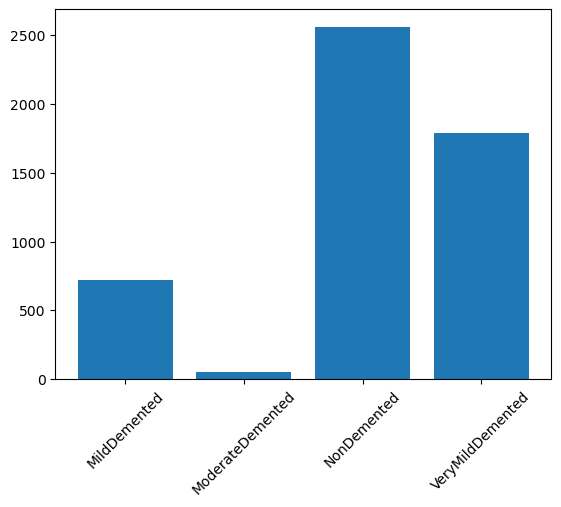

In [8]:
plt.bar(classes, class_distributions.values())
plt.xticks(rotation=45)

##### As we can see, the moderate demented class is highly imbalanced, which in some sense, is the most "crucial" class to predict successfully.
##### To understand better the dimensions of the our data, we'll plot the heatmap of each of the classes to understand the "average" look of a sample from each class

##### Reading the data from disk into memory

In [9]:
from PIL import Image

In [10]:
def get_image_dimensions(image_path):
    image = Image.open(image_path)
    return image.width, image.height

In [11]:
from tqdm.notebook import tqdm

In [12]:
def image_to_numpy(image_path):
    image = Image.open(image_path)
    return np.array(image).astype(np.uint8)

In [13]:
# setting tensor to store all images' pixels
images = np.empty((5121, 208, 176), dtype=np.uint8)
class_to_idx = {}
for i in range(len(classes)):
    class_to_idx[classes[i]] = i
images_labels = np.empty(5121, dtype=np.uint8)

In [14]:
image_idx = 0
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{train_base_dir}/{class_name}')):
        image_path = f'{train_base_dir}/{class_name}/{image_name}'
        images[image_idx] = image_to_numpy(image_path)
        images_labels[image_idx] = class_to_idx[class_name]
        image_idx += 1

  0%|          | 0/717 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/2560 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

In [15]:
import seaborn as sns

#### Displaying heatmap for each class - whiter is stronger density, i.e: hyperintense

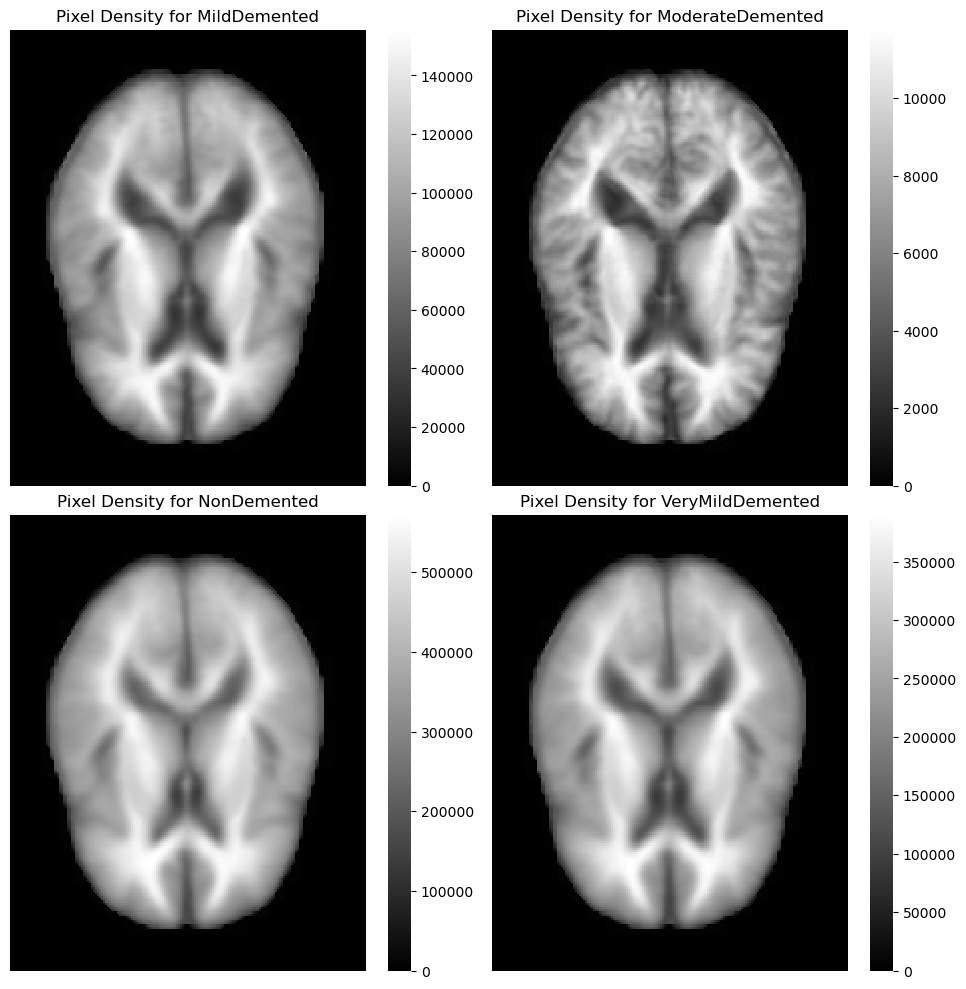

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Pixel Density for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

##### The first thing that caught my mind is that there are a lot of black pixels which can be dropped to lower the dimensionality of the input.
##### Second, we can see that the most of the parts of the brain in the non demented class are hyperintense, where in the moderate demeneted brains, most of the parts are hypointense.
##### This initial observation can help us down the line, but as we'll see, not enough to easily classify images in an if-else fashion.
##### So the first thing we'll do is drop all the irrelevant empty pixels.

##### We'll go for the more "straight" approach and notuse any unsupervised learning methods like PCA and SVD. SVD we'll be used later for noise cleaning.

In [17]:
# get leftmost non empty pixel
non_empty_pixels = np.where(images > 0)[1:]

In [18]:
non_empty_pixels

(array([ 16,  16,  16, ..., 191, 191, 191], dtype=int64),
 array([ 56,  64,  65, ..., 112, 115, 116], dtype=int64))

In [19]:
uppermost_pixel = np.min(non_empty_pixels[0])
bottommost_pixel = np.max(non_empty_pixels[0])
leftmost_pixel = np.min(non_empty_pixels[1])
rightmost_pixel = np.max(non_empty_pixels[1])

In [20]:
# dropping the pixels
images = images[:, uppermost_pixel:bottommost_pixel+1, leftmost_pixel:rightmost_pixel+1]

In [21]:
images.shape

(5121, 176, 144)

##### As we can see, we dropped $208*176-176*144=11264$ pixels

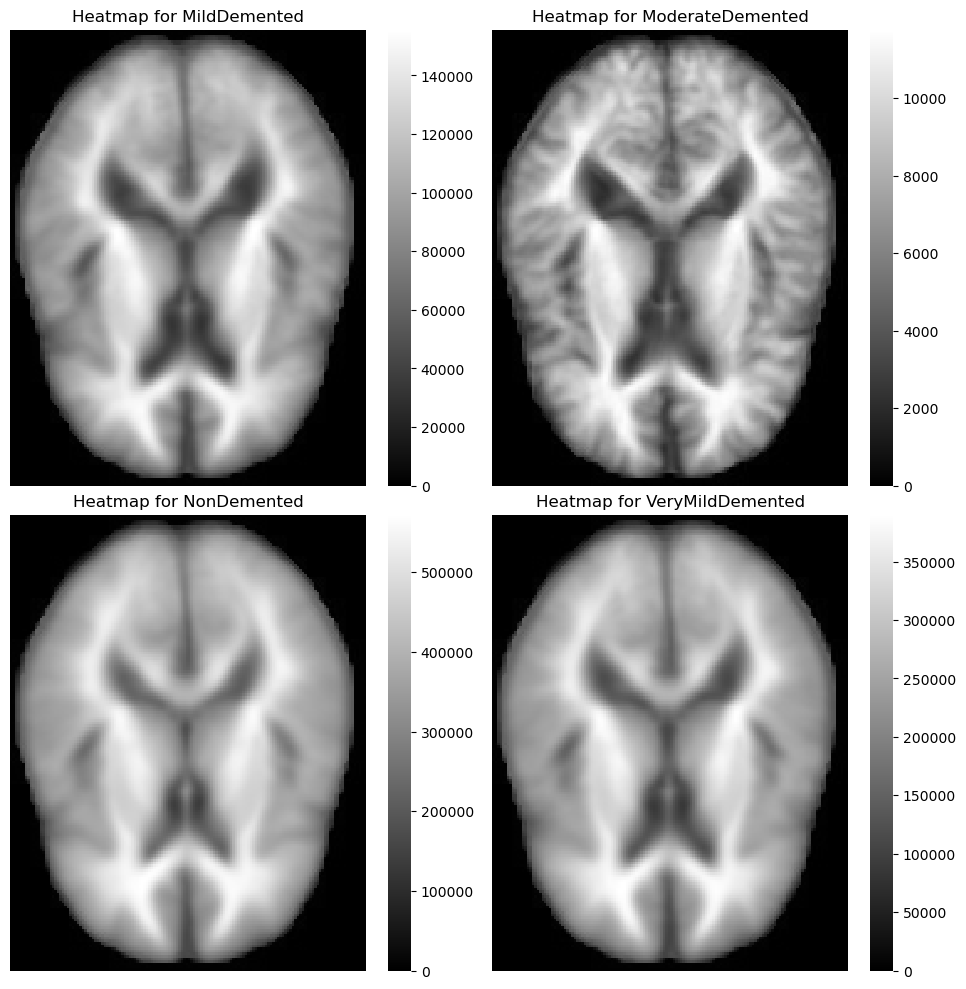

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Heatmap for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

##### Previously we saw the disribution of the labels of the images, but what about the distribution of the pixels? We want to understand which pixels values occur more in the different classes.

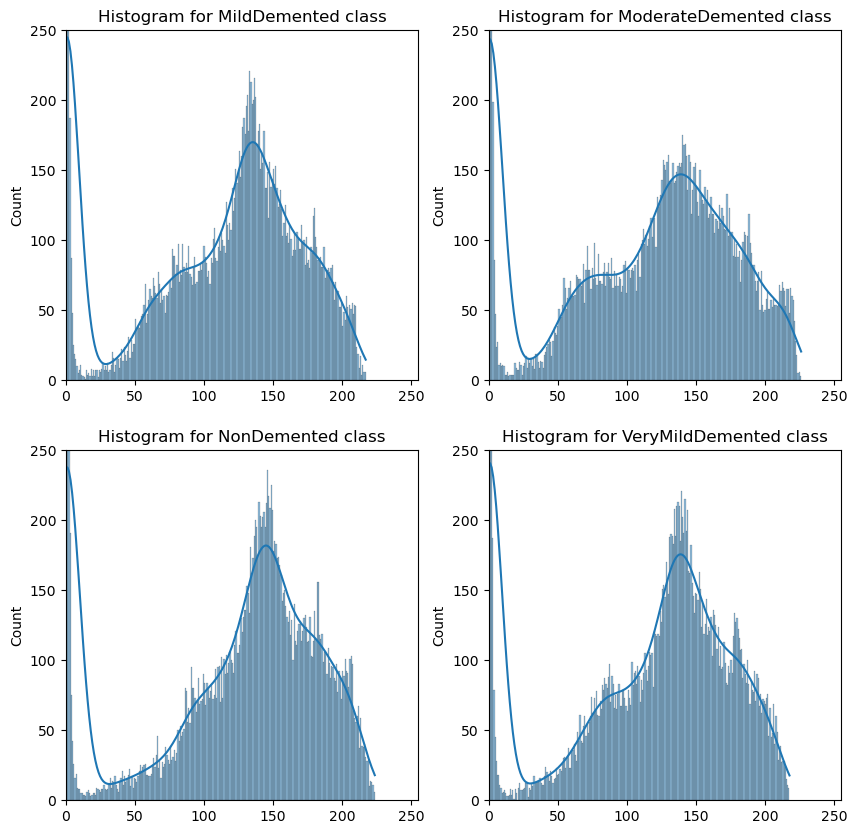

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'Histogram for {classes[i]} class')
    sns.histplot(images[images_labels == i].mean(axis=0).flatten(), bins=255, kde=True, ax=ax)
    ax.set_xlim([0, 255])
    ax.set_ylim([0, 250])
    # ax.hist(images[:, random_pixels[i]//176, random_pixels[i]%144])

##### We've limited the y axis range since the 0 value has a very large number of occurrences since it surrounds the actual brain in each image.
##### But we can see that the disributions are similar between the classes, specifically in the 3 lowest classes - non demented, very mild demented and mild demented.
##### This also emphasizes the hyperintense areas in those classes and the hypointense areas in the moderate demeneted classes since there's a difference of ~50 between the highest occurring pixel in the moderate class and the others.

##### Now what about distributions of the pixels themselves? We'll take a random sample of 10 from the $176*144$ pixels and show their disribution, to try and see whether some pixels "behave" the same.

#### Show distribution of random pixels per class

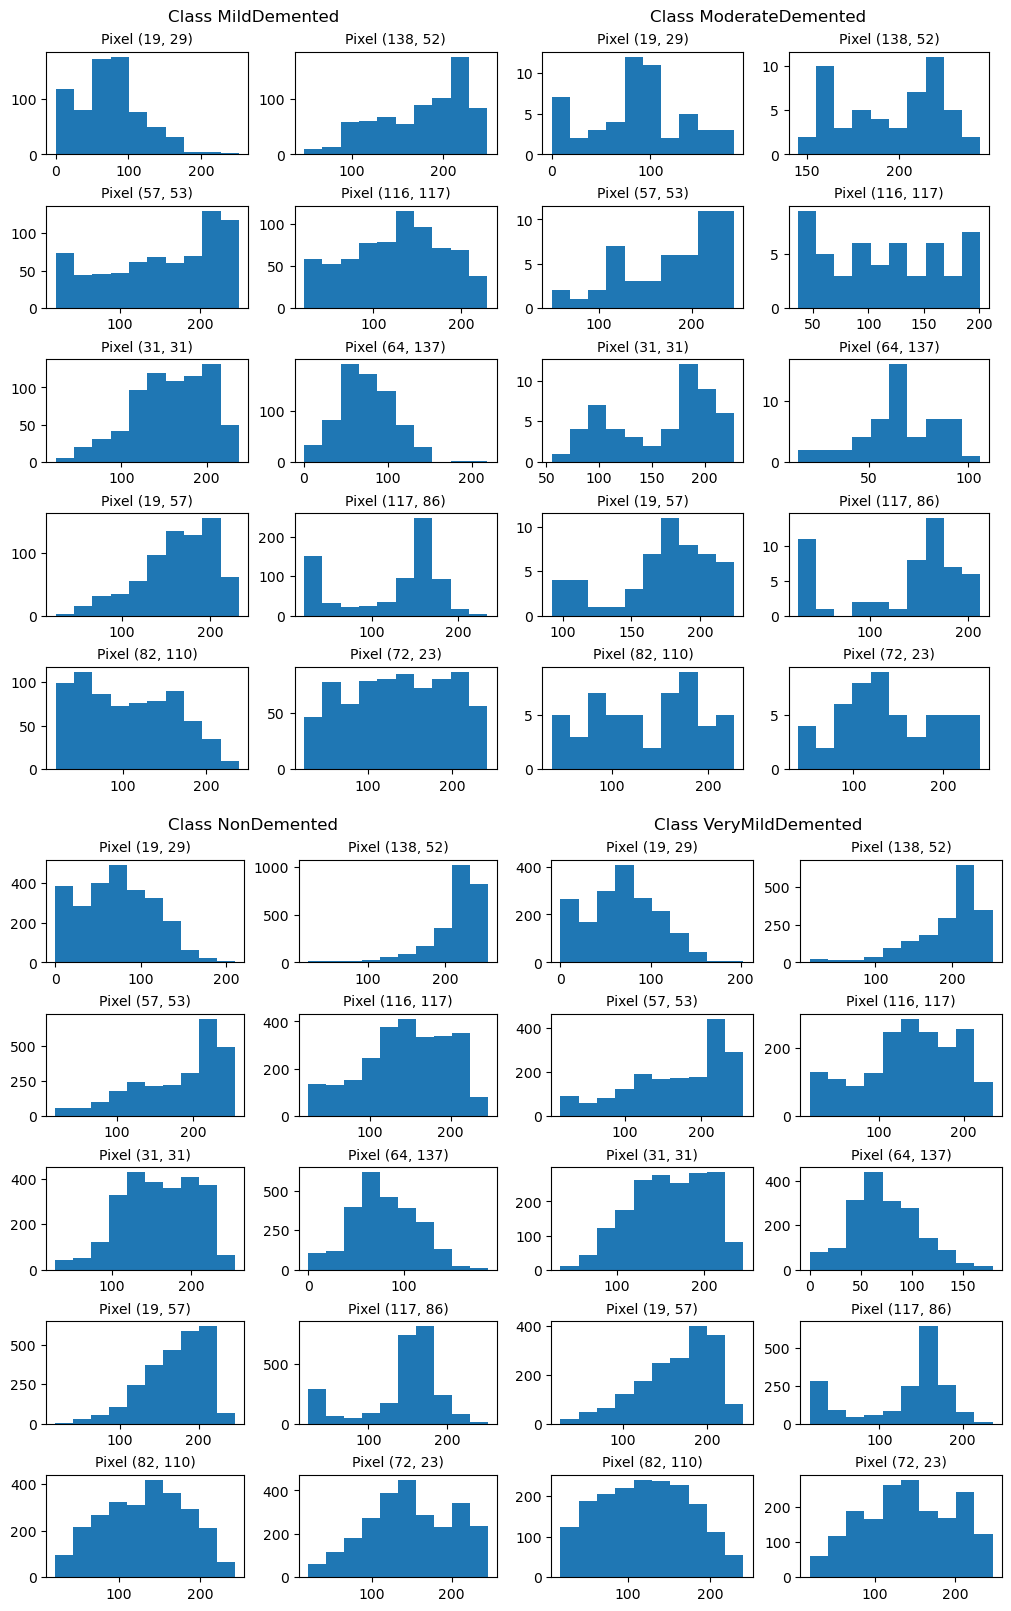

In [24]:
fig = plt.figure(constrained_layout=True, figsize=(10, 16))
subfigs = fig.subfigures(2, 2)

random_pixels = np.random.default_rng().choice(176 * 144, size=10, replace=False)

for class_idx, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Class {classes[class_idx]}')
    axes = subfig.subplots(5, 2)
    class_images = images[np.where(images_labels == class_idx)]
    for i in range(10):
        ax = axes[i//2, i%2]
        ax.hist(class_images[:, random_pixels[i]//176, random_pixels[i]%144])
        ax.set_title(f'Pixel {(random_pixels[i]//176, random_pixels[i]%144)}', fontsize=10)

##### We can see there are pixels that are gaussian disributed and some that are very close to that, and even some that are neither.

##### Now comes the question of normalizing. A heads up, we won't be normalizing our images since the results of our trials and studied have shown a great decline, whereas the non normalized input have shown bigger promise.
##### This has a good explanation, which we'll get into later.
#### NOT normalizing the images as the decoding process is less successful when dealing with a small range of numbers

##### Since we're dealing with images, we can't help but see the frequency domain structure of the images, so we'll use the Fourier Transform to do exactly that, and maybe see some patterns and/or noise and have some conclusions.

In [25]:
def fourier_transformed(image, shifted=False):
    # centering the frequency values for better visibility
    fft_image = np.fft.fft2(image)
    # fft_conj_image = np.conj(fft_image)
    # # will always be non-negative real values
    # transformed = np.real(fft_image * fft_conj_image)
    if shifted:
        return np.fft.fftshift(fft_image)
    return fft_image

def inverse_fourier_transformed(transformed_image, shifted=False):
    if shifted:
        transformed_image = np.fft.ifftshift(transformed_image)
    # getting the rescaled spatial image, shifted
    inverse_fft_image = np.fft.ifft2(transformed_image)
    # inverse_fft_conj_image = np.conj(inverse_fft_image)
    # inverse_transformed = np.real(inverse_fft_image * inverse_fft_conj_image)
    inverse_transformed = np.real(inverse_fft_image)
    # inverse_transformed = np.abs(inverse_fft_image)
    # normalizing the values as norm of each pixel can be very high
    inverse_transformed = 255 * inverse_transformed / inverse_transformed.max()
    return inverse_transformed


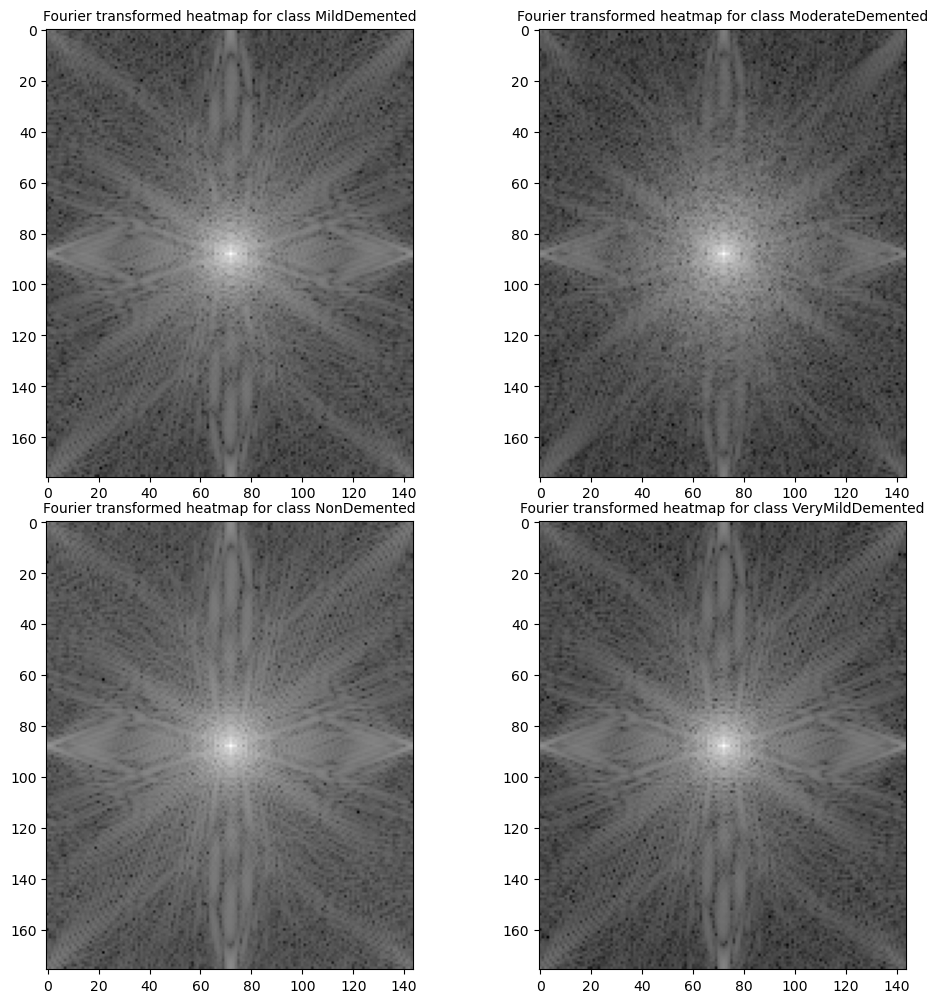

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    ax.set_title(f'Fourier transformed heatmap for class {classes[i]}', fontsize=10)
    class_images_mean = images[images_labels == i].mean(axis=0)
    class_mean_fourier_transformed = fourier_transformed(class_images_mean, False)
    ax.imshow(np.log10(np.abs(np.fft.fftshift(class_mean_fourier_transformed))), cmap='gray')
    # ax.imshow(class_images_mean, cmap='gray')

##### We've taken a look at the heatmap of each class, as we'll do throughout the process, and we can see pretty similar structure between the classes (the spade shape) but with a lot of noise along with it (the black dots and the brighter diagonal "rays"). 
##### So let's compare each heatmap with a single sample:

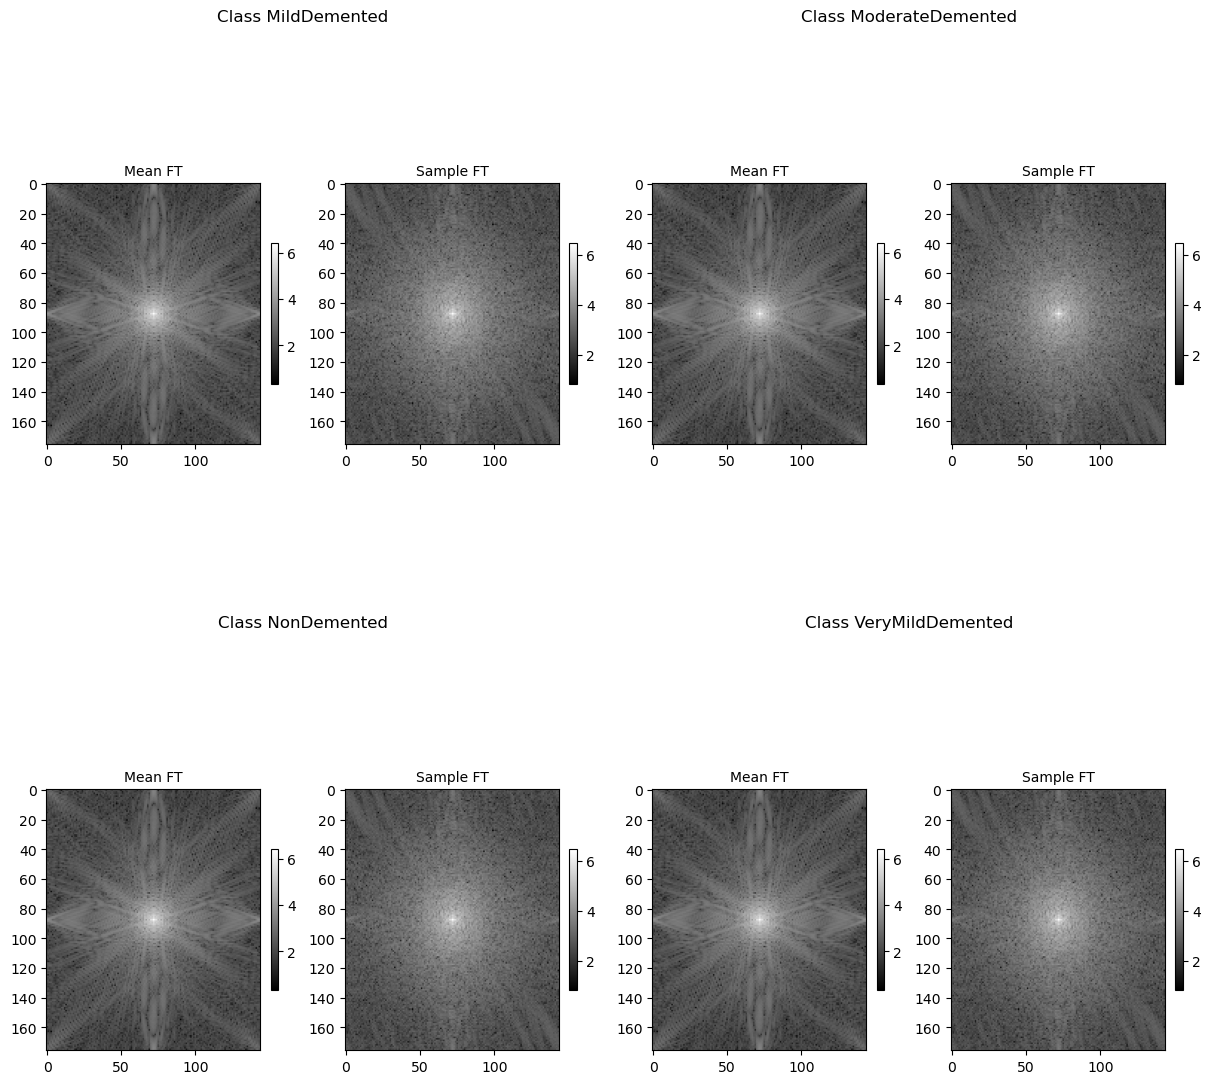

In [27]:
epsilon = 0.000001

fig = plt.figure(constrained_layout=True, figsize=(12, 12))
subfigs = fig.subfigures(2, 2)

for class_idx, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Class {classes[class_idx]}')
    axes = subfig.subplots(1, 2)
    class_images = images[np.where(images_labels == class_idx)]
    class_images_mean = images[images_labels == i].mean(axis=0)
    class_mean_fourier_transformed = fourier_transformed(class_images_mean, False)
    scaled_transformed = np.log10(np.abs(np.fft.fftshift(class_mean_fourier_transformed)))
    pos0 = axes[0].imshow(scaled_transformed, cmap='gray', vmin=scaled_transformed.min(), vmax=scaled_transformed.max())
    axes[0].set_title('Mean FT', fontsize=10)
    fig.colorbar(pos0, ax=axes[0], shrink=0.25)

    class_image = images[images_labels == i][0]
    image_fourier_transformed_shifted = fourier_transformed(class_image, shifted=True)
    scaled_shifted_transformed = np.log10(np.abs(image_fourier_transformed_shifted) + epsilon)
    pos1 = axes[1].imshow(scaled_shifted_transformed, cmap='gray', vmin=scaled_shifted_transformed.min(), vmax=scaled_shifted_transformed.max())
    axes[1].set_title('Sample FT', fontsize=10)
    fig.colorbar(pos1, ax=axes[1], shrink=0.25)


##### That's pretty interestring. We can see that from a single sample the spade-like shape of the heatmap is much weaker than the heatmap's. This leads to the conclusion that there are images that have stronger spade-like shape, and some do not.
##### Obviously, this is true since the Fourier Transform of $f+g$ is the Fourier Transform of $f$ + the Fourier Transform of $g$.

##### We'll try to clean some of that noise by applying a threshold filter on the images to see whether the noise cleaning can lead to new conclusions and that the images sharpness and detail aren't harmed.

In [28]:
ones = np.ones_like(images[0])
epsilon = 0.000001
border = 0
center_y, center_x = ones.shape[0]//2, ones.shape[1]//2
center = np.array([center_y, center_x])

ones[center_y-border:center_y+border+1, center_x-border:center_x+border+1] = 0 + epsilon
v, u = np.mgrid[:images[0].shape[0], :images[0].shape[1]]

distances_from_center = np.sqrt(
    np.square(v - center[0]) + np.square(u - center[1])
)
threshold = 40
mask = distances_from_center <= threshold

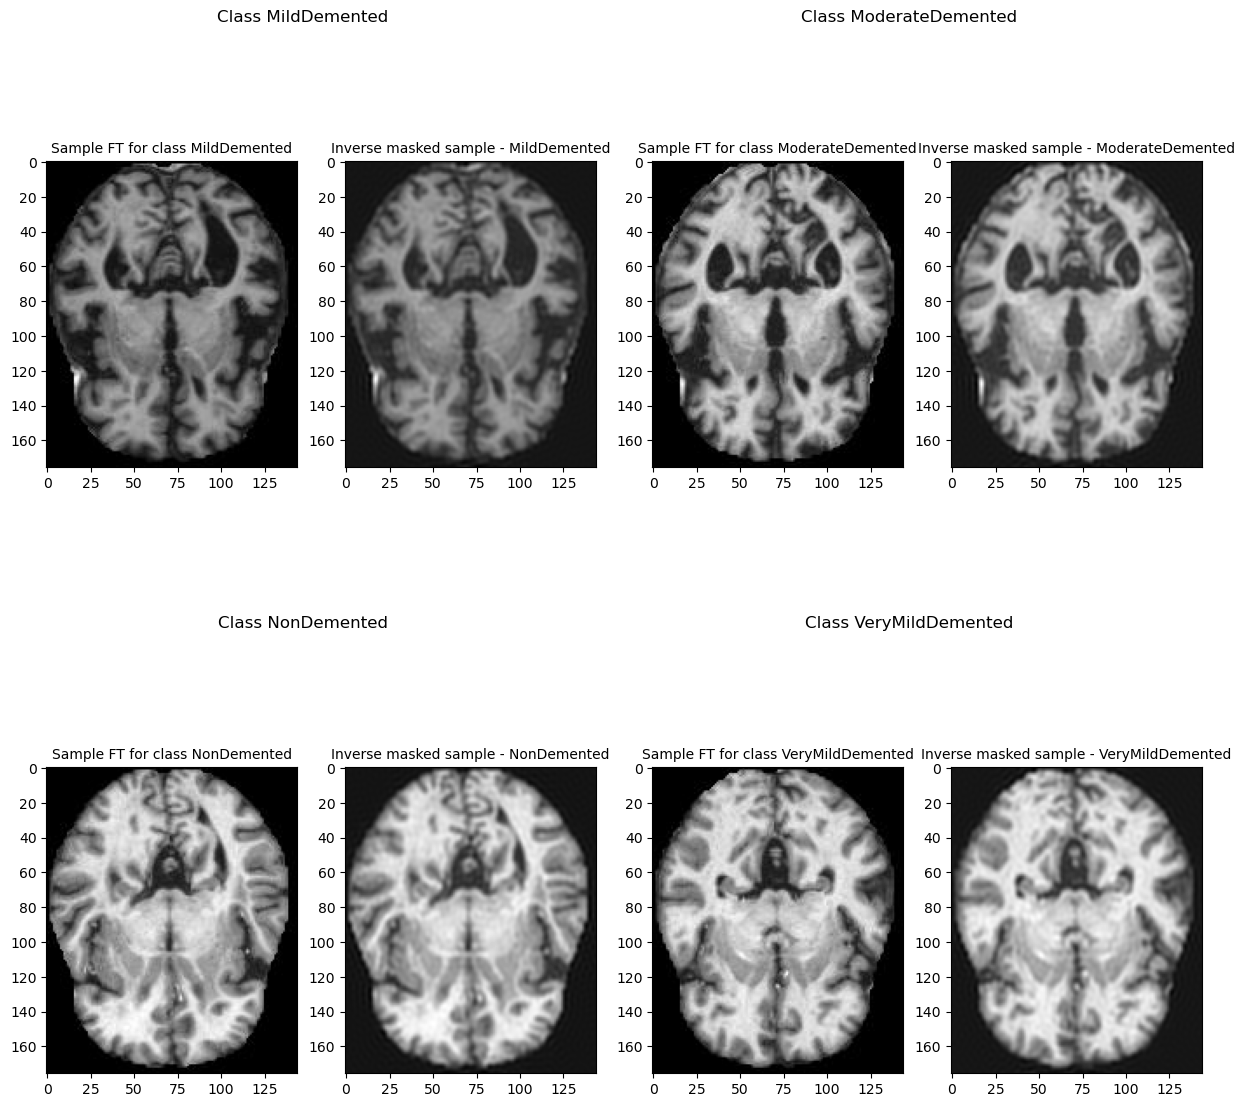

In [29]:
fig = plt.figure(constrained_layout=True, figsize=(12, 12))
subfigs = fig.subfigures(2, 2)

for class_idx, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Class {classes[class_idx]}')
    axes = subfig.subplots(1, 2)
    class_images = images[np.where(images_labels == class_idx)]

    class_image = class_images[0]
    image_fourier_transformed_shifted_masked = fourier_transformed(class_image, shifted=True) * mask
    # axes[0].imshow(np.log10(np.abs(image_fourier_transformed_shifted_masked) + epsilon), cmap='gray')
    axes[0].imshow(class_image, cmap='gray')
    axes[0].set_title(f'Sample FT for class {classes[class_idx]}', fontsize=10)

    inverse_masked_image = np.fft.ifft2(np.fft.ifftshift(image_fourier_transformed_shifted_masked)).real
    axes[1].imshow(inverse_masked_image, cmap='gray')
    axes[1].set_title(f'Inverse masked sample - {classes[class_idx]}', fontsize=10)

##### The details of the images weren't harmed but we do see a more blurred image, which is not what we want.
##### Let's see how's the Fourier Transform looks like on a 2 dimensional plane (and not 3 like with the images).

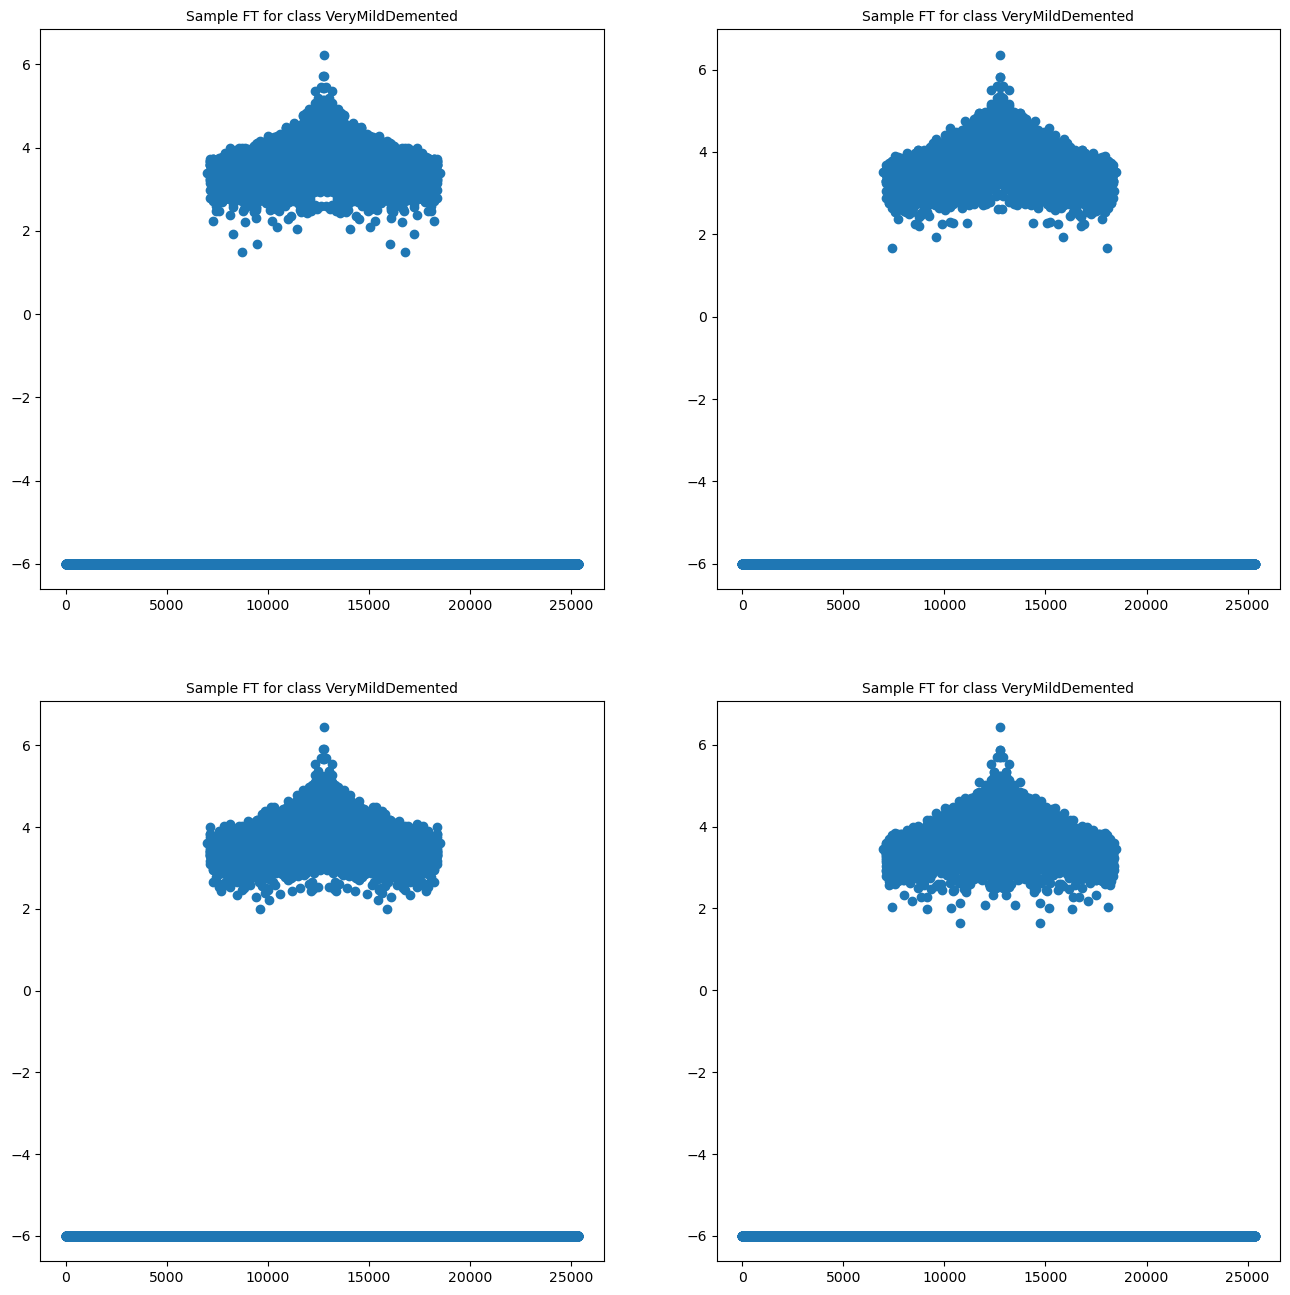

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

for i in range(4):
    class_images = images[np.where(images_labels == i)]

    class_image = class_images[0]
    image_fourier_transformed_shifted_flattened = fourier_transformed(class_image, shifted=True).flatten() * mask.flatten()
    axes[i//2, i%2].scatter(np.arange(image_fourier_transformed_shifted_flattened.shape[0]), np.log10(np.abs(image_fourier_transformed_shifted_flattened) + epsilon))
    axes[i//2, i%2].set_title(f'Sample FT for class {classes[class_idx]}', fontsize=10)

##### There's almost no difference at all between the images, so that's not a good direction to go with.

##### And just to understand the power of the Fourier Transform, we've restored the image from the frequency domain to the spatial domain (since the frequency domain contains complex numbers, there's a possible side effect of a data loss, or in other words, noise cleaning, which can be beneficial).

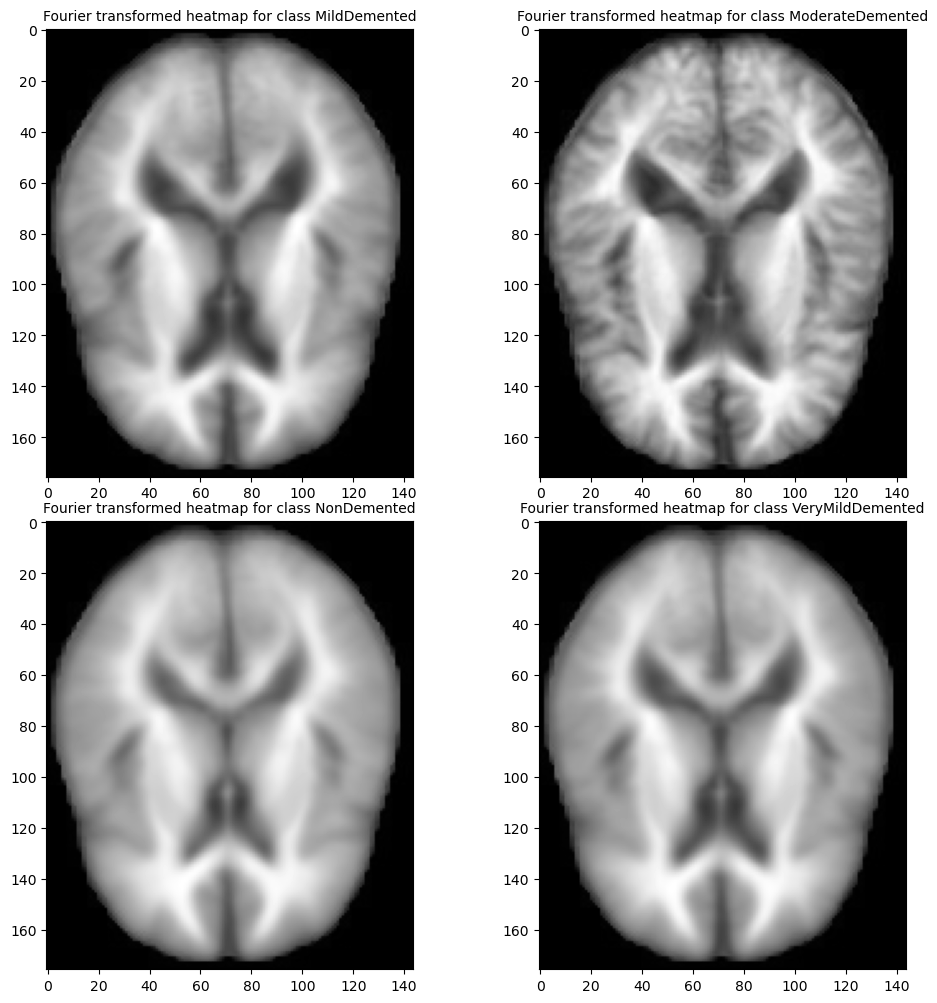

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    ax.set_title(f'Fourier transformed heatmap for class {classes[i]}', fontsize=10)
    class_images_mean = images[images_labels == i].mean(axis=0)
    class_mean_fourier_transformed = fourier_transformed(class_images_mean)
    class_mean_inverse_fourier_transformed = inverse_fourier_transformed(class_mean_fourier_transformed)
    ax.imshow(class_mean_inverse_fourier_transformed, cmap='gray')

##### Our previous attempts to distinguish the classes weren't that successful, so instead of using a threshold filter, we'll try to use some of the more "classic" ones and hope for some potential assumptions and/or conclusions.

In [32]:
import scipy as sp

In [33]:
def plot_side_by_side(first_images, second_images, first_title, second_title):
    # plot
    fig = plt.figure(constrained_layout=True, figsize=(18, 10))
    subfigs = fig.subfigures(2, 2)

    for class_idx, subfig in enumerate(subfigs.flat):
        subfig.suptitle(classes[class_idx])
        axes = subfig.subplots(1, 2)

        blurred_images = first_images[np.where(images_labels == class_idx)]
        blurred_heatmap = np.sum(blurred_images, axis=0)
        sns.heatmap(blurred_heatmap, ax=axes[0], cmap='gray')
        axes[0].set_title(first_title)
        axes[0].get_yaxis().set_visible(False)
        axes[0].get_xaxis().set_visible(False)

        original_images = second_images[np.where(images_labels == class_idx)]
        original_heatmap = np.sum(original_images, axis=0)
        sns.heatmap(original_heatmap, ax=axes[1], cmap='gray')
        axes[1].set_title(second_title)
        axes[1].get_yaxis().set_visible(False)
        axes[1].get_xaxis().set_visible(False)

#### Applying max filter with a 3x3 kernel

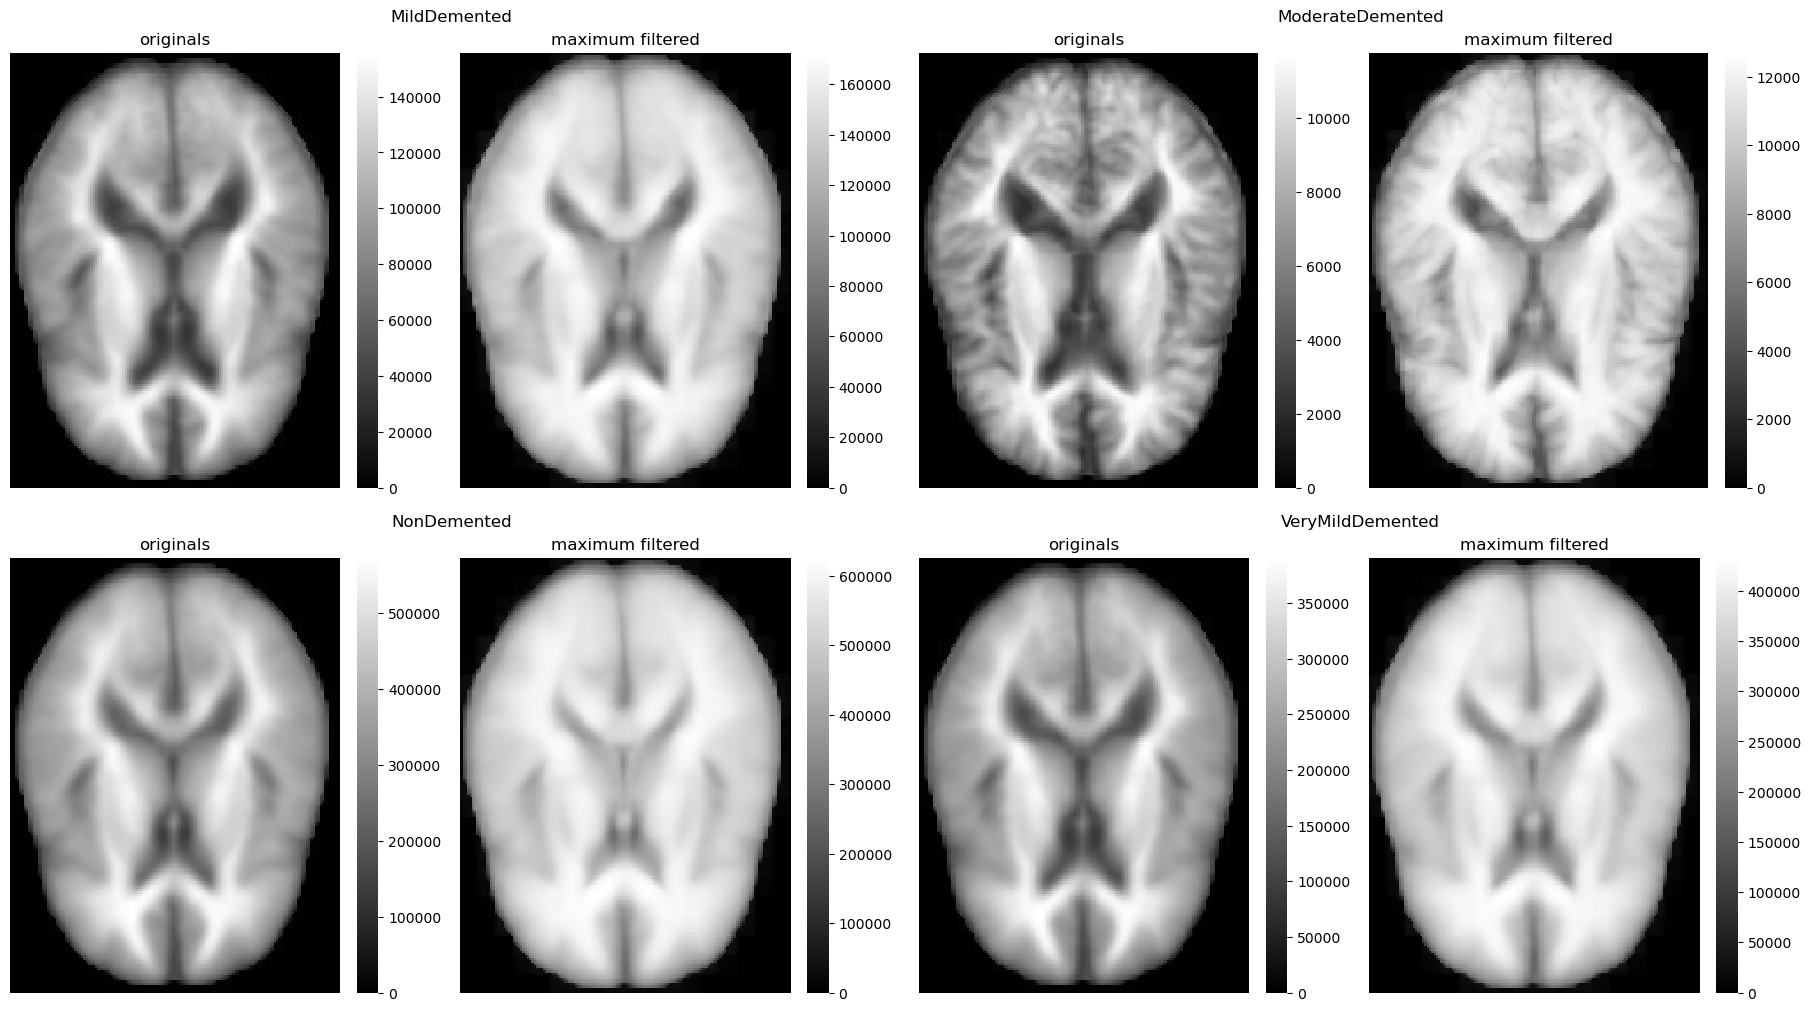

In [34]:
plot_side_by_side(images, sp.ndimage.maximum_filter(images, size=3), 'originals', 'maximum filtered')

#### Minimum filter

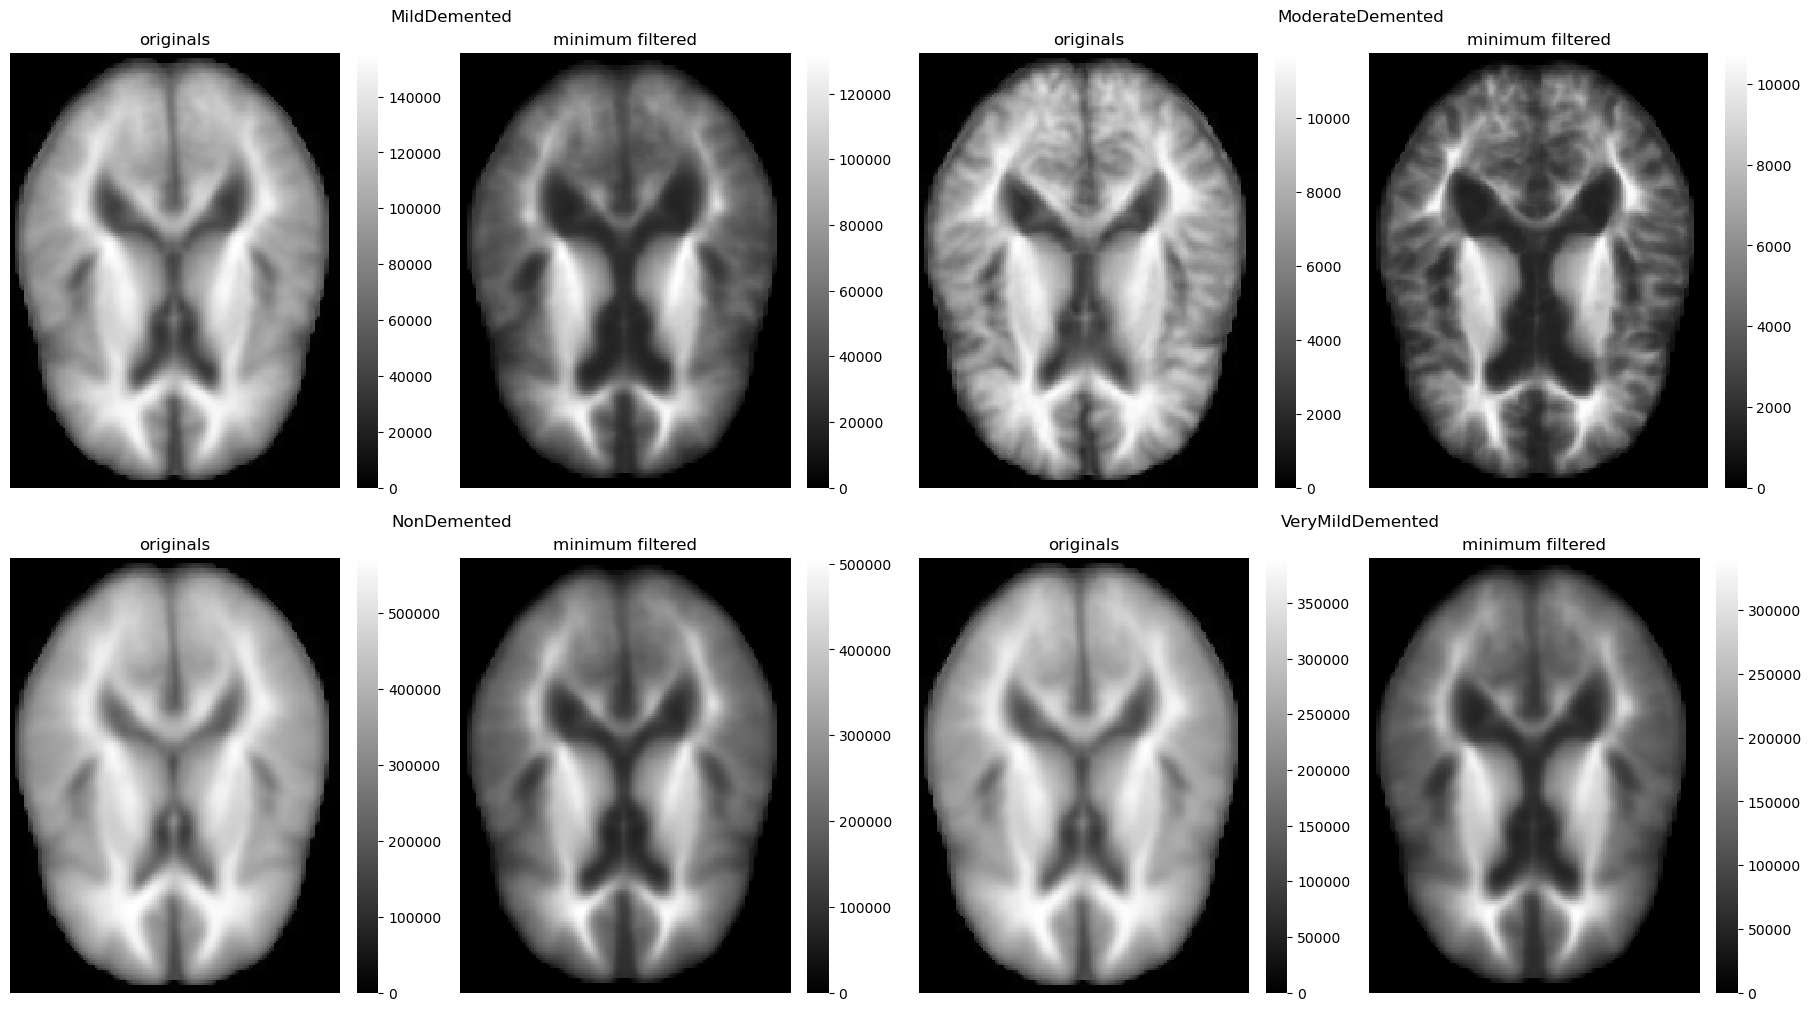

In [35]:
plot_side_by_side(images, sp.ndimage.minimum_filter(images, size=3), 'originals', 'minimum filtered')

##### As we can see, the maximum and minimum filters don't help us distinguish between the non demented and the very mild demented class. Both results looks fairly the same.
##### Additionally, we can see in the minimum filter plot that the moderate demented class has a lot of hypointense areas, whereas the non demented and very mild demented ones have a fair share of hyperintense areas, regardless of the filter.

##### Next we'll go for the gradients-based approach.
##### A gradient in an image is basically the vector that points to the nearest hypointense area for the pixel.
##### Since our moderate demented class has a big share of changes in its structure, we expect a larger amount of detail in the gradient-based images, whereas in the other classes, a much smaller amount.
##### The main filters that calculate (an approximation) the gradient best are the [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) and [Prewitt](https://en.wikipedia.org/wiki/Prewitt_operator) filters.

#### Sobel filter

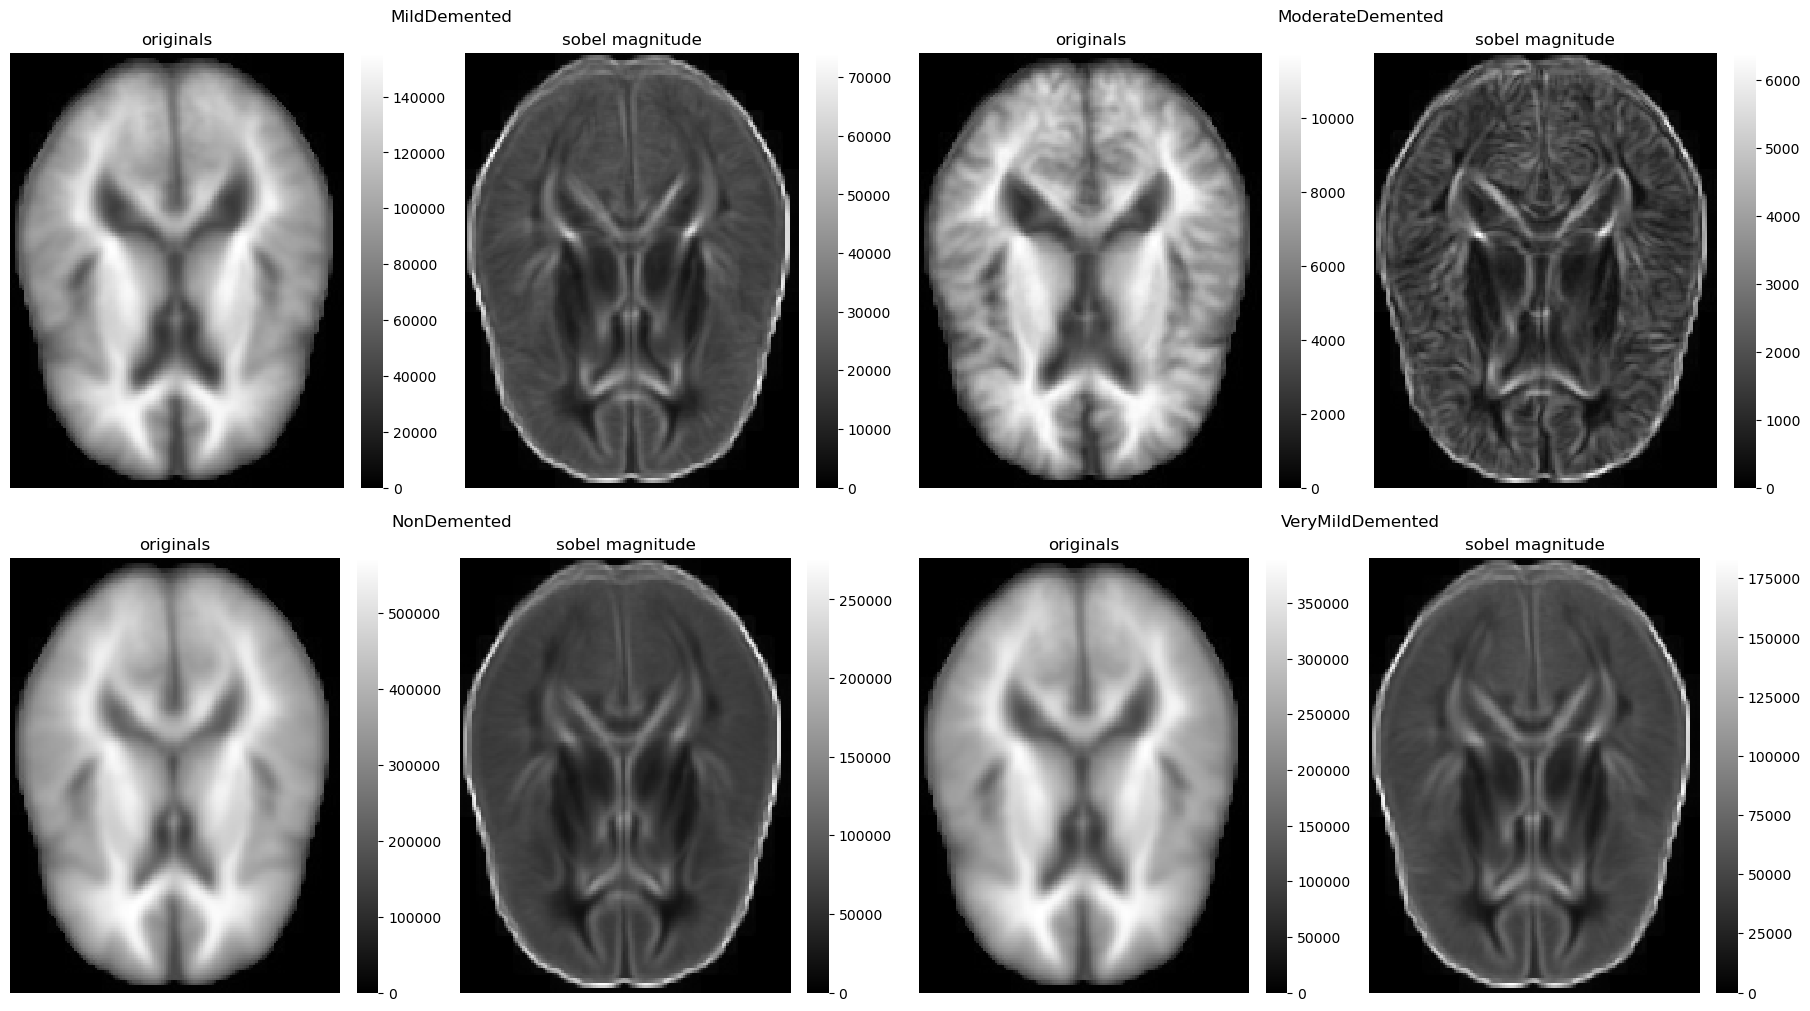

In [36]:
sobel_x_gradients = sp.ndimage.sobel(images / 255, axis=1)
sobel_y_gradients = sp.ndimage.sobel(images / 255, axis=2)
sobel_magnitude = np.sqrt(sobel_x_gradients ** 2 + sobel_y_gradients ** 2)
sobel_magnitude = 255 * sobel_magnitude / np.max(sobel_magnitude)
sobel_gradient_angle = np.arctan2(sobel_y_gradients, sobel_x_gradients)

plot_side_by_side(images, sobel_magnitude, 'originals', 'sobel magnitude')

#### Prewitt filter

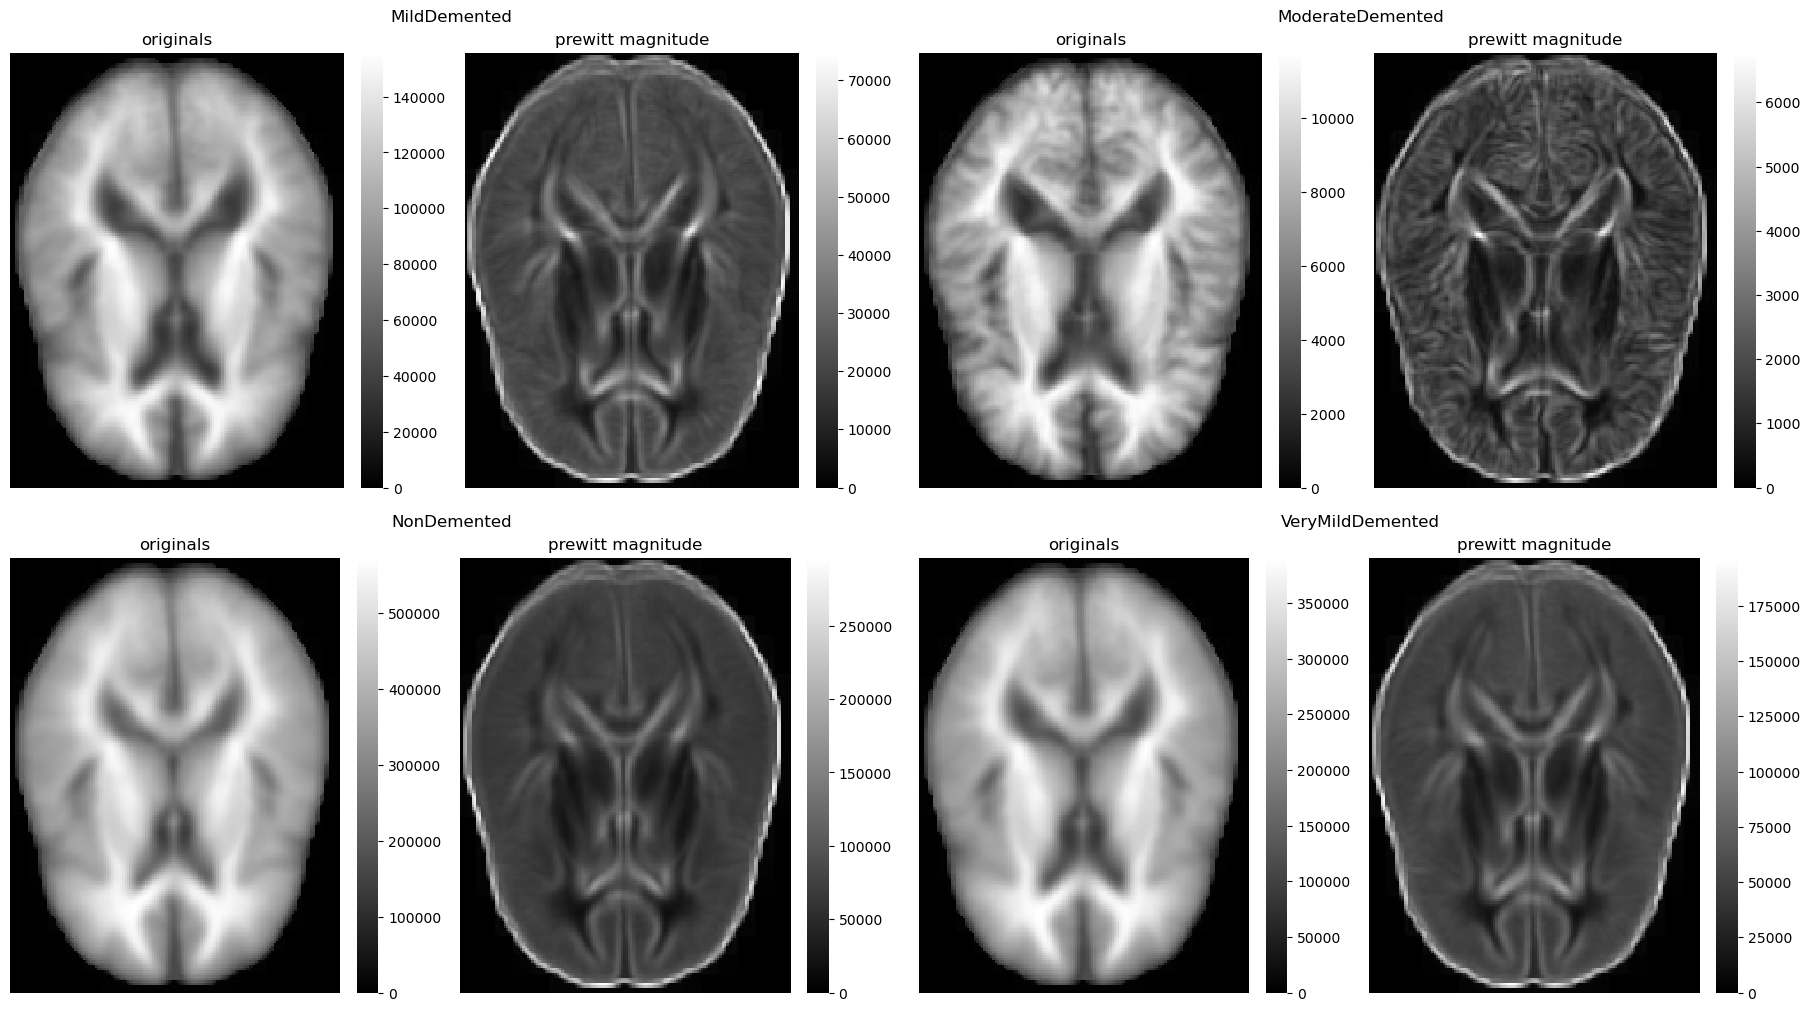

In [37]:
prewitt_x_gradients = sp.ndimage.prewitt(images / 255, axis=1)
prewitt_y_gradients = sp.ndimage.prewitt(images / 255, axis=2)
prewitt_magnitude = np.sqrt(prewitt_y_gradients ** 2 + prewitt_x_gradients ** 2)
prewitt_magnitude = 255 * prewitt_magnitude / prewitt_magnitude.max()
prewitt_gradient_angle = np.arctan2(prewitt_y_gradients, prewitt_x_gradients)

plot_side_by_side(images, prewitt_magnitude, 'originals', 'prewitt magnitude')

#### Compare prewitt with sobel

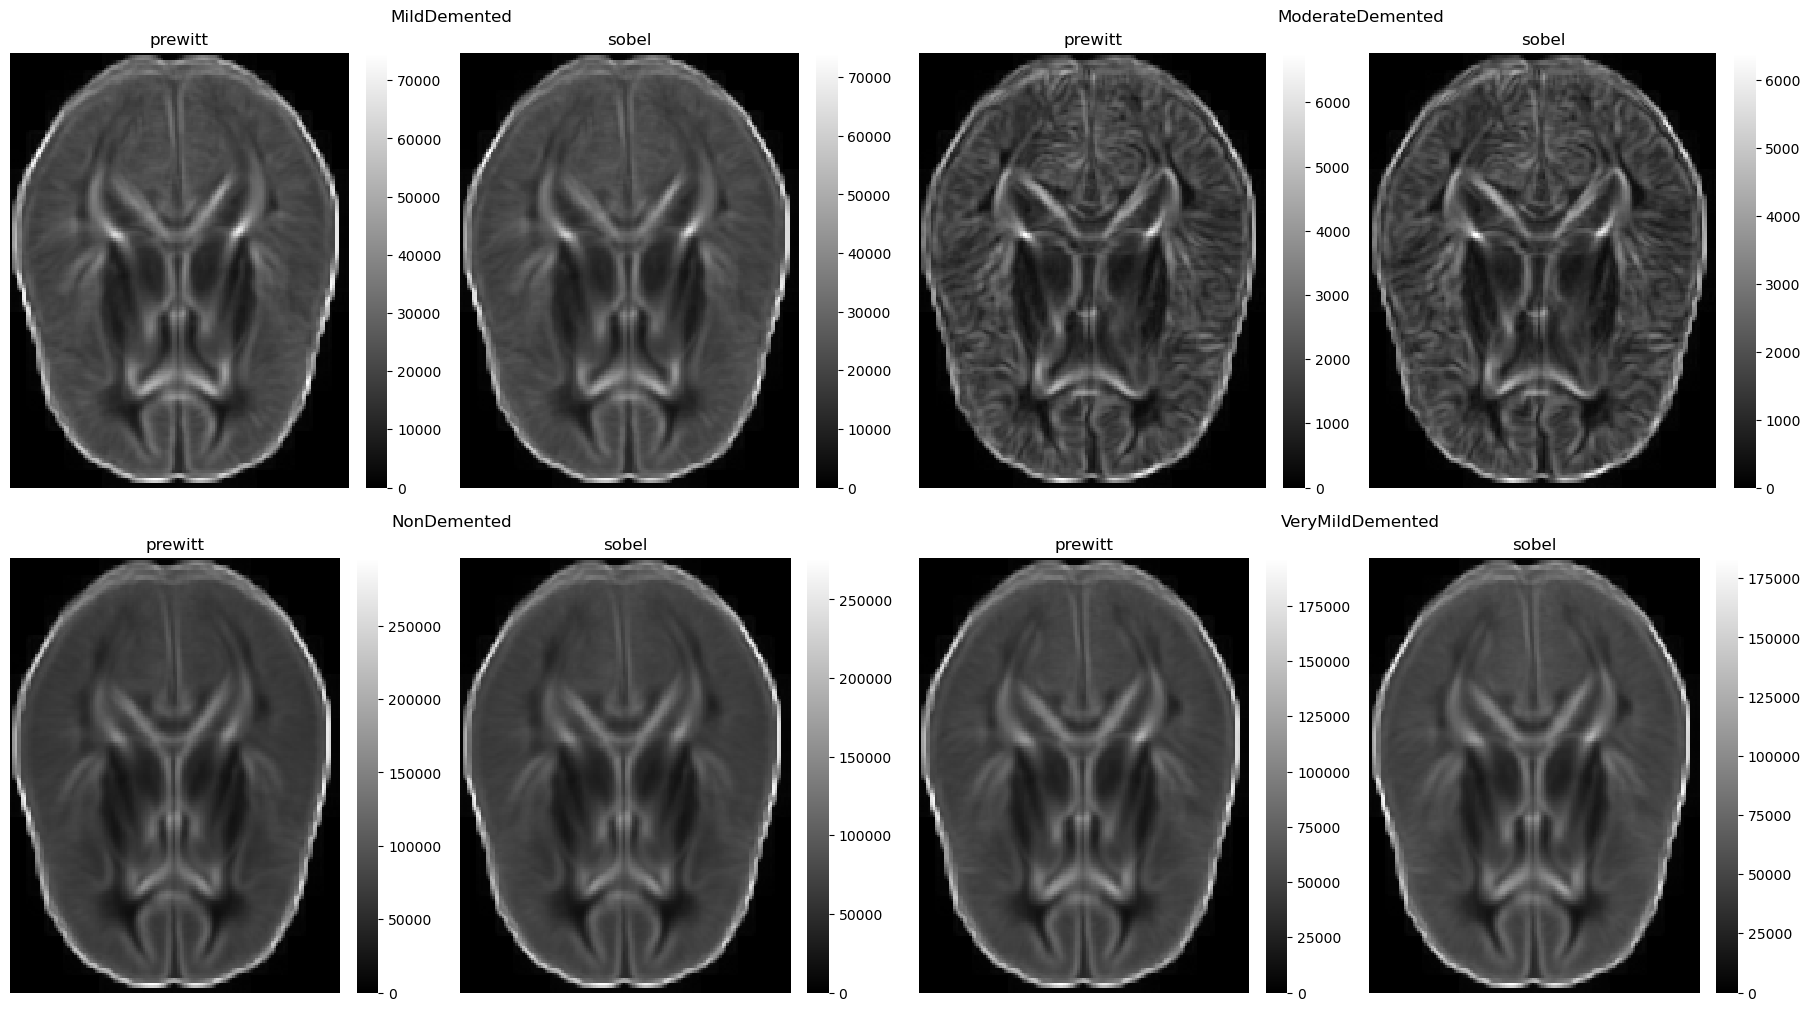

In [38]:
plot_side_by_side(prewitt_magnitude, sobel_magnitude, 'prewitt', 'sobel')

##### As we can see, the moderated demented class truly has more "detail" in its gradient filtered image, whereas the other have less.
##### Also, it was expected to see a nearly identical results between the two filters since they're both approximations of the gradients.
##### Just for the fun of it, we can illustrate the gradient of each pixel and see it does point to the nearest hypointense area of the pixel.

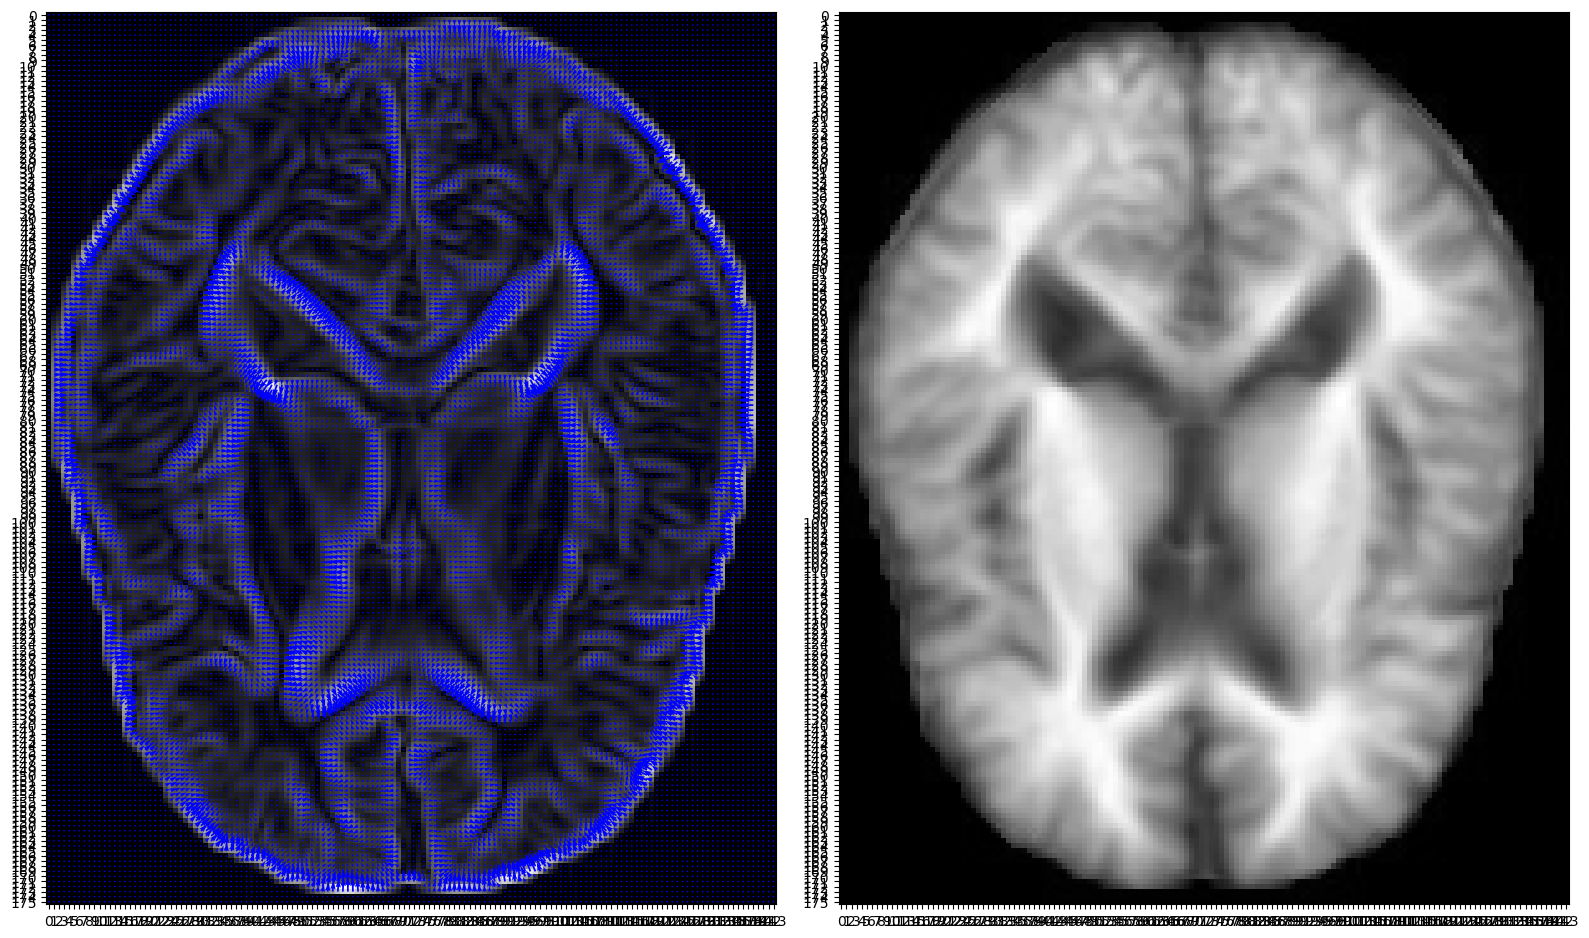

In [39]:
# x_start, x_end = 60, 80
# y_start, y_end = 70, 85
x_start, x_end = 0, images.shape[2]
y_start, y_end = 0, images.shape[1]

# test_image = images[0, y_start:y_end, x_start:x_end]
group_idx = 1
images_group = images[images_labels == group_idx]
test_image = np.sum(images_group, axis=0) / len(images_group)
# print(test_image, images[0, 84, 79])
prewitt_test_y_gradient = sp.ndimage.prewitt(test_image, axis=0)
prewitt_test_x_gradient = sp.ndimage.prewitt(test_image, axis=1)
prewitt_test_magnitude = np.sqrt(prewitt_test_x_gradient ** 2 + prewitt_test_y_gradient ** 2)
prewitt_test_magnitude = 255 * prewitt_test_magnitude / prewitt_test_magnitude.max()
prewitt_test_gradient_angle = np.arctan2(prewitt_test_y_gradient, prewitt_test_x_gradient)

y, x = np.mgrid[:y_end-y_start, :x_end-x_start]

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

plt.setp(axes, xticks=np.arange(x_end - x_start), xticklabels=np.arange(x_start, x_end),
         yticks=np.arange(y_end - y_start), yticklabels=np.arange(y_start, y_end))
# plt.xticks(rotation=45)
# plt.yticks(rotation=45)

axes[0].imshow(prewitt_test_magnitude, cmap='gray', zorder=1)
# quiver plot is shown upside down so multiplying y coordinates and gradients by -1 for flipping the image and the arrows direction, respectively
axes[0].quiver(x, y, prewitt_test_x_gradient, prewitt_test_y_gradient,
            color='blue', angles='xy', scale_units='xy', units='width', scale=90, zorder=2)
# axes[0].streamplot(x, y, sobel_test_x_gradient, sobel_test_y_gradient,
#                    density=(test_image.shape[0]/30, test_image.shape[1]/30),
#                    arrowsize=1, integration_direction='forward', zorder=2)
axes[1].imshow(test_image, cmap='gray')
fig.tight_layout()

##### There's an additional filter that's being broadly used in image processing and that is the Laplace filter, which helps in identifying edges (like Sobel and Prewitt) and areas/regions in an image that have a big difference between them, i.e: lines that separate different areas in terms of pixel values.
##### We can see the filtered images below.

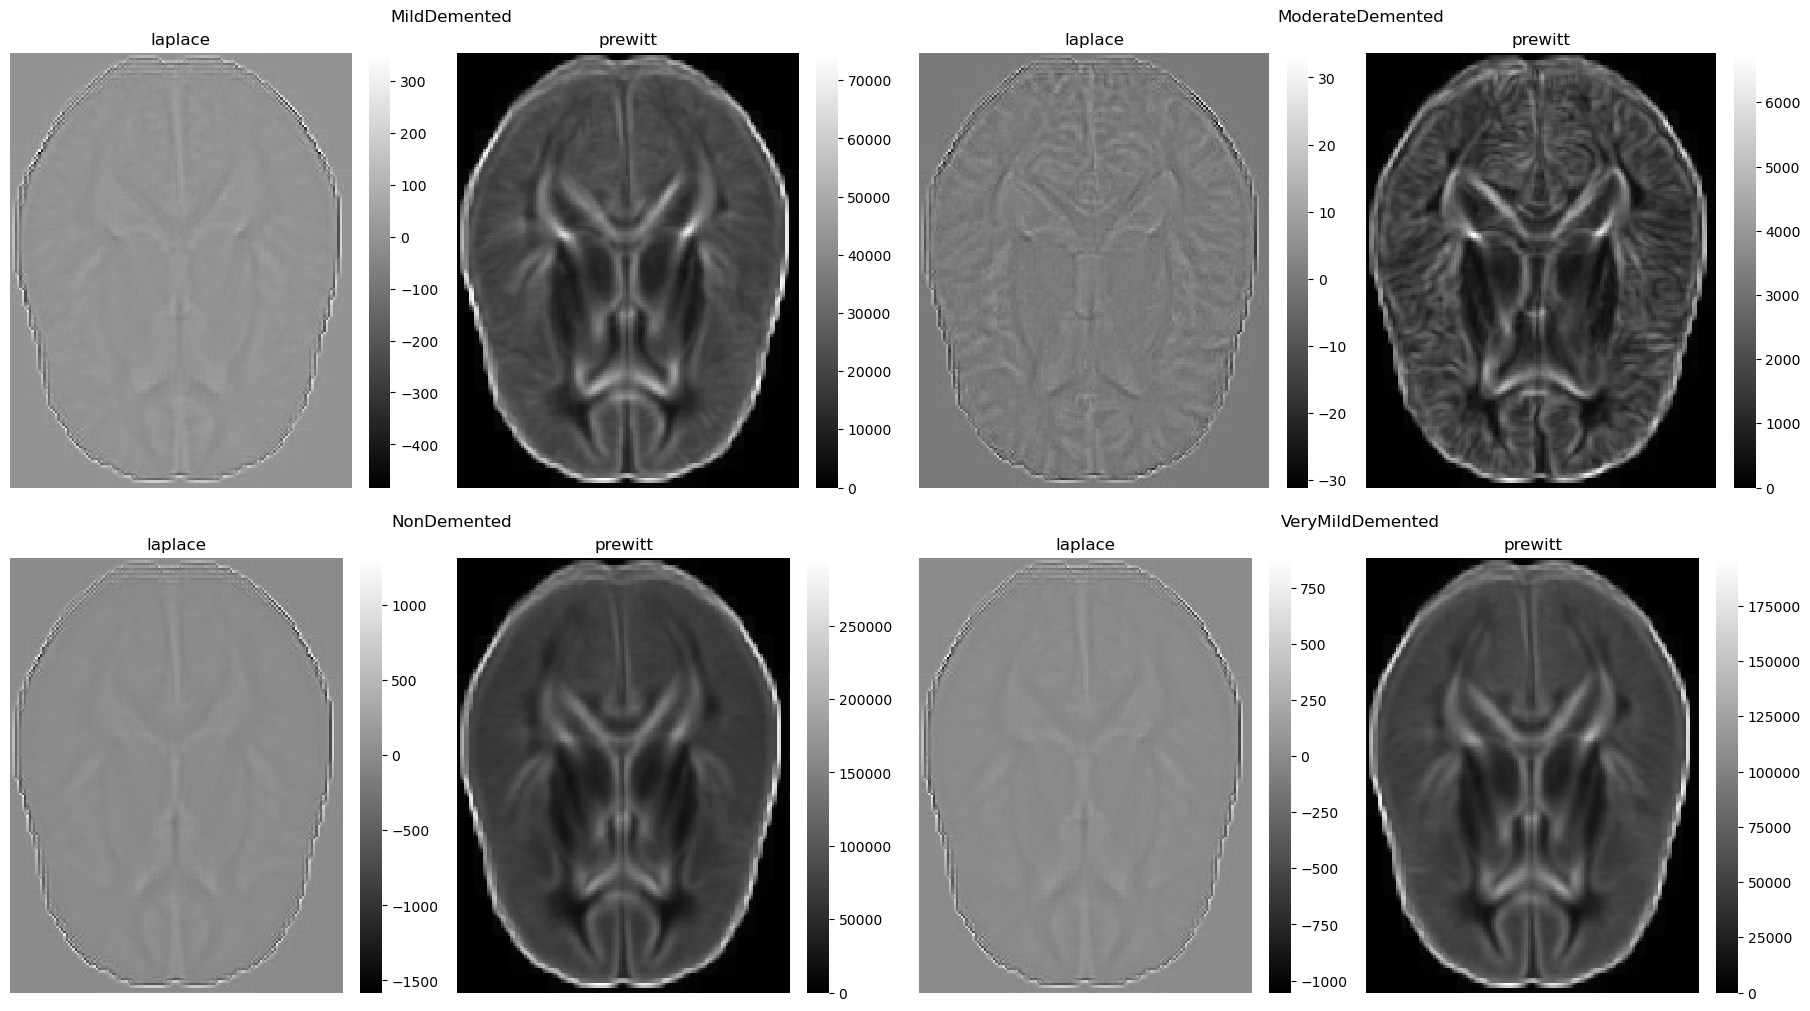

In [40]:
plot_side_by_side(sp.ndimage.laplace(images / 255, cval=0), prewitt_magnitude, 'laplace', 'prewitt')

##### Well, we've a fair share of techniques and approaches to understand how to better distinguish between the classes, but to no avail.
##### And since we're dealing with a very small dataset (~5000) images, augmentation is pretty much a necessity for a better generalization capabilities of our future models.

##### Our first attempt of augmentation is another "classic" approach - rotation.
##### We'll rotate the images by a certain angle and add the result to our dataset, where each rotated image will have the same label as the original image, which we'll enhance our dataset by doubling it in size.

In [41]:
rotated_25 = sp.ndimage.rotate(images, 25, axes=(1, 2), reshape=False)

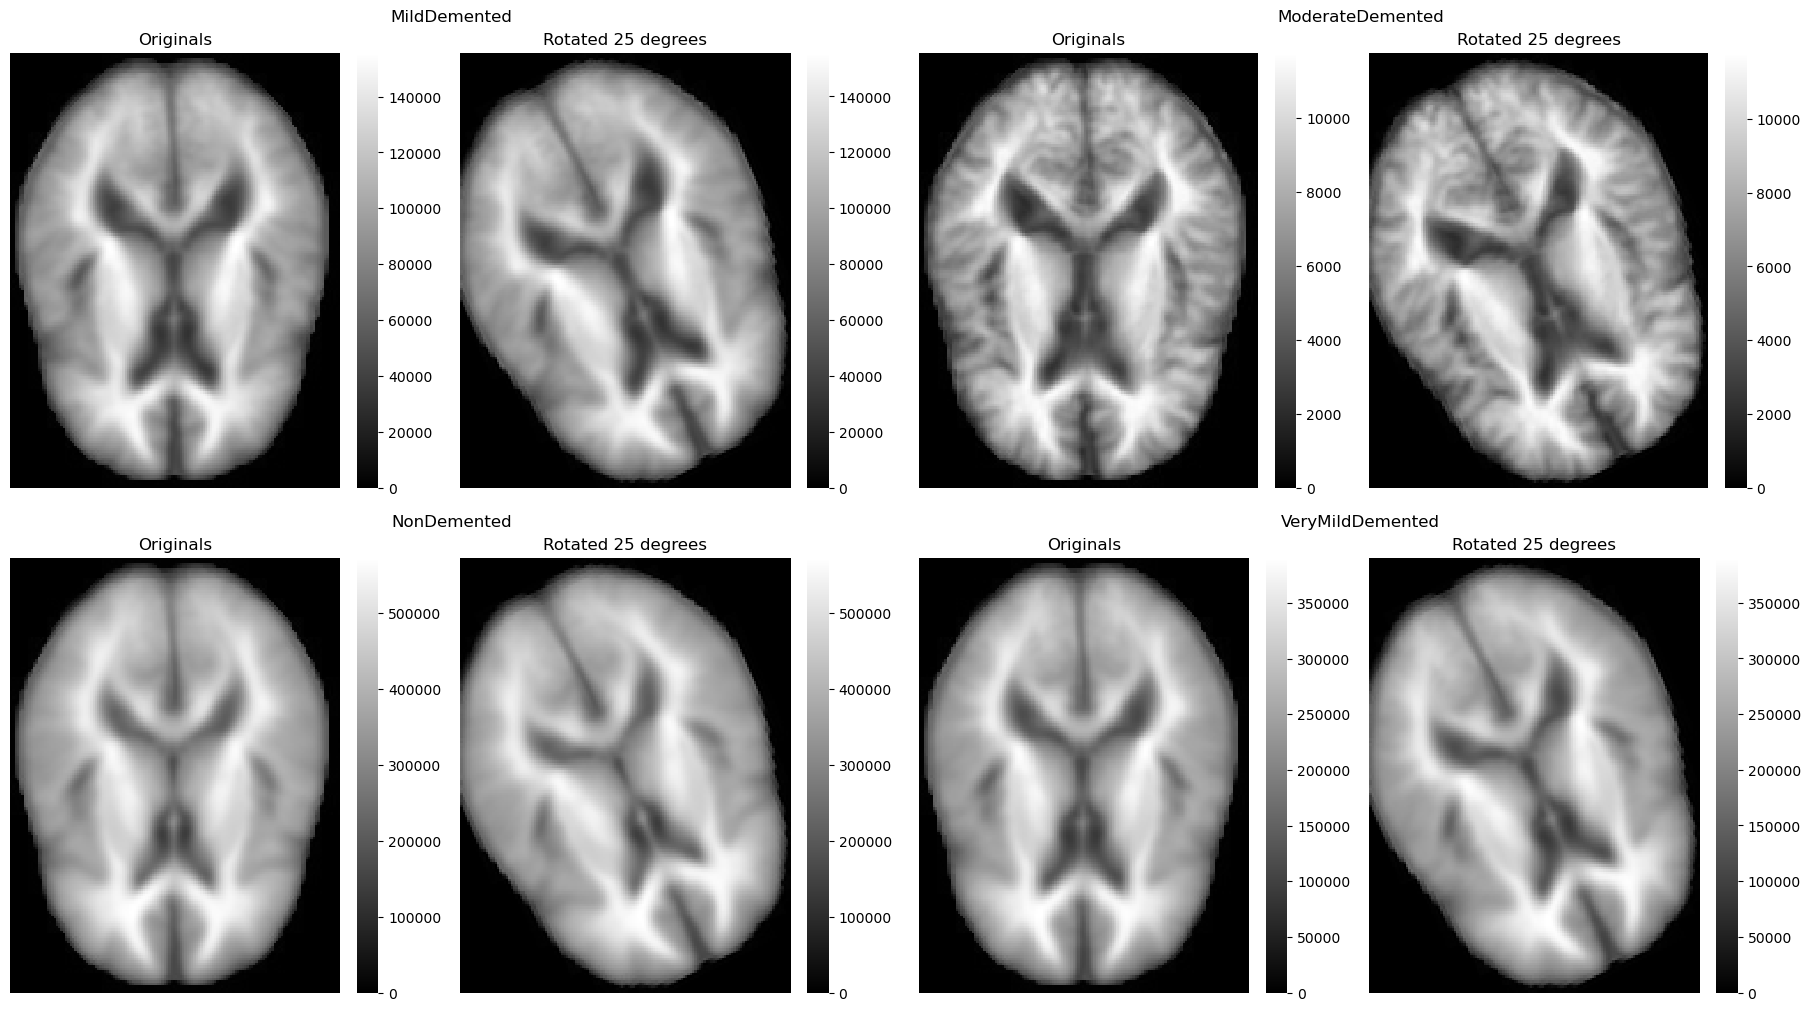

In [42]:
plot_side_by_side(images, rotated_25, 'Originals', 'Rotated 25 degrees')

In [43]:
# images = np.concatenate((images, rotated_25), axis=0)
# images_labels = np.concatenate((images_labels, images_labels), axis=0)
del rotated_25

##### Unfortunately, after many trials and errors, I've found that the rotated images actually detract the models' performances so I've decided to neglect this path.
##### BUT, and that's a big but, as a medical-biotech-neuroscience-enthusiast, and not a physician/biotechnician/neuroscientist, I can help myself to assume that the brain is striving to be symmetric and so we can flip each image horizontally and call it a "new image".

In [44]:
# flipping the horizontal axis as we're assuming (getting also the -25 rotated images)
flipped_images = images[..., ::-1]

In [45]:
images = np.concatenate((images, flipped_images), axis=0)
images_labels = np.concatenate((images_labels, images_labels), axis=0)

In [46]:
images.shape, images_labels.shape

((10242, 176, 144), (10242,))

##### And here we go, we've doubled our dataset's size by this unofficial assumption.

##### But that's not enough. What if we can use "GenAI" to create new brains out of nowhere?
##### I really don't like the term "GenAI", but since it's a buzzword at the moment, I might as well join the mainstream.

##### So our goal here is to create a model that learns from our existing dataset (the doubled in size) and later will have the ability to create new images of brains out of thin air, where "thin air"="sampling from a certain disribution".

##### But there's a catch - say I have that model, and it performs magnificently. The next step is to sample from that certain distribution and then we'll get a brain image. How can we know what class that image belongs to? Without the correct label, we can't train a classifier, since it's a supervised learning.
##### There are 2 options that I thought of regarding this problem:
##### 1. If we can sample from an "area" that contains only a single class, we can be pretty confident that the generated image is of the same class.
##### But here comes the catch, if each class has a separate "area", or more formally, cluster, we don't need a smart classifier model to do the job for us, but to use a clustering algorithm, which is much faster and efficient.
##### Now let's see why that's not the case:

##### 2. Since our model will never be perfect, we can assume that given an input image, we can try to pass to some mathematical pipeline (which has an official name), that tries to extract the most important features (let's say $k$ features where the images has $n$ features, and $k < n$) out of the image, and later it tries to reconstruct the image from those K features. This way, we'll get a fairly similar image to the original one, but also fairly different since this "pipeline" is not perfect. That way, we know the generated image is the most similar to the original so we know its class label, and at the same time we're getting a different "brain". It's a win-win!

##### Now to formalize it a bit, this "methematical pipeline" is called an AutoEncoder, where we'll be trying to compress each image to a lower dimension space (the encoder's job) and then try and restore that image from that space (the decoder's job). We'll know how close we were using the Mean Squared Error loss function ($MSE$). We also tried using the $RMSE$ (Root MSE), but the results were worse.

In [47]:
import torch
from torch import nn

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Preparing data for PyTorch

In [49]:
class AlzheimerDataset(torch.utils.data.Dataset):
    def __init__(self, np_images, np_labels, transform=None, target_transform=None):
        self.X = torch.from_numpy(np_images).to(torch.float32).unsqueeze(dim=1) # adding the single channel
        self.y = torch.from_numpy(np_labels)
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        images = self.X[idx]
        labels = self.y[idx]
        if self.transform:
            images = self.transform(images)
        if self.target_transform:
            labels = self.target_transform(labels)
        
        return images, labels

##### I've written separate modules for the model definition and building to make the notebook cleaner. All of the explanations are written there as comments in the code.

##### One important thing to note is that we didn't use a "regular" AutoEncoder, we used a Variational AutoEncoder, which is an AutoEncoder that regularizes the latent space (the space that we're compressing the input to) to be normally distributed. This type of regularization is done using the KL Divergence function (as a regularization term). The KL Divergence function computes the difference between a sampled distribution and a true distribution. So for our use case, we'll compute the difference between the latent space's distribution and a standard normal distribution, i.e: $Z \sim N(\underline{\mu}=\mathbf{0}, \underline{\sigma^2}=\mathbf{1})$. Adding this difference to our loss function as a regularization term, will force the latent space to be normally distributed.
##### So our loss function will be $MSE + \lambda * KL$, where $\lambda$ is the regularization coefficient.
##### The reason for using this regularization term, is to easily sample data as input to the decoder for it to generate new data. Since the gaussian distribution has many use cases and effects, using it as a middle ground is a good idea. For instance, generating another "average" sample will take to sample from a point near the mean with a standard deviation that's smaller than 1, i.e: $\mu + \epsilon$, where $\epsilon<\sigma$.
##### But as explained above, we can't just sample and generate an image, since we won't know its class, but we will be able to somehow measure our model's quality.

In [50]:
import modules.models
from modules.models.models import ConvAutoEncoder, kl_divergence_loss

##### We'll create a train and validation datasets first, to check throughout the training our model's generalization capabilities on the validation dataset.

In [51]:
perm = torch.randperm(images.shape[0])
val_indices = perm[:int(images.shape[0] * 0.15)].numpy()
train_indices = np.setdiff1d(np.arange(images.shape[0]), val_indices)

In [52]:
from modules.models.dataset import AlzheimerDataset

# alzheimer_dataset = AlzheimerDataset(images, images_labels)

train_dataset = AlzheimerDataset(images[train_indices], images_labels[train_indices])
val_dataset = AlzheimerDataset(images[val_indices], images_labels[val_indices])

##### Making sure the distributions are the same between the datasets.

In [53]:
np.unique(train_dataset.y, return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([1251,   88, 4336, 3031], dtype=int64))

In [54]:
np.unique(val_dataset.y, return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([183,  16, 784, 553], dtype=int64))

##### I knew I'll be running the same notebook over and over again, mainly to find the best hyperparameters for our model.
##### And sometimes the results were better, even though I just restarted the python kernel and reran the notebook. So my solution to keep track of all the runs was to create a database to store all the trainings, including hyperparameters ranges, values, etc.
##### For the tuning, I used Optuna. Before starting to use it, I tweaked the hyperparamters myself after each training process, which was tedious and slow, and obviously not efficient at all. So Optuna came to the rescue and improved the model's performances by almost 75% (initially the model finished with a loss value of ~2000, since we didn't normalize the pixels. And after a few studies with Optuna the average loss value was lower than 800, where the best one was ~550).

##### NOTE: Optuna has an option for a callback function after each trial, and I used that option to report the trial's data to the database (I used postgres). The report is sent via an http request (to an API written with FastAPI), just to simplify the process. Before writing the API, I had to connect manually to the database, which slowed down the training process significantly because every connection and query took ~5 seconds. And after writing the API, I used asynchronous calls for the reports which sped up the training.

In [55]:
import modules.db
from modules.db.optuna_report import report_optuna_trial, get_best_hyperparameters, get_last_study_id

##### To visualize the training progress, and not just with tqdm, I used TensorBoard for the visualization. After each epoch I sent a reconstructed image and the relevant metrics (MSE loss, KL loss and overall loss) to see how to model's progressing.

In [56]:
# using tensorboard for displaying training progress and metrices in real time
from torch.utils.tensorboard import SummaryWriter
import optuna

In [57]:
if not os.path.isdir('./data/studies'):
    os.mkdir('./data/studies')
studies_directories = os.listdir('./data/studies/')
# if last study wasn't finished, use that study id in tensorboard and later on in resuming the optuna study
if len(studies_directories) > 0:
    current_study_id = studies_directories[-1].split('-')[-1]
# last study finished successfully so we'll start a brand new one
else:
    current_study_id = get_last_study_id() + 1
current_study_id = get_last_study_id() + 1

In [58]:
current_study_id

52

##### Writing the training functions. Since we're using a special type of regularization, our training loop is a bit different, since our model's output is not just the reconstructed images.
##### Also, we've specified the tensorboard calls here.

In [59]:
def train_epoch(model, optimizer, loss, regularization_lambda, dataloader, val_dataset, overall_losses,
                kl_divergence_losses, main_losses,val_overall_losses, val_kl_divergence_losses, val_main_losses,
                epoch, scheduler=None, writer=None):
    for _, (batch_X, _) in enumerate(dataloader):
        batch_X = batch_X.to(device)
        
        optimizer.zero_grad()
        
        _, batch_encoded_mean, batch_encoded_log_var, batch_decoded_output = model(batch_X)
        # batch_decoded_output = autoencoder(batch_X)
    
        batch_main_loss = loss(batch_decoded_output, batch_X)
        # batch_loss = batch_main_loss
        batch_kl_divergence_loss = kl_divergence_loss(batch_encoded_mean, batch_encoded_log_var)
        batch_loss = batch_main_loss + regularization_lambda * batch_kl_divergence_loss
    
        batch_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            overall_losses[epoch] += batch_loss.item() * batch_X.shape[0]
            kl_divergence_losses[epoch] += batch_kl_divergence_loss.item() * batch_X.shape[0]
            main_losses[epoch] += batch_main_loss.item() * batch_X.shape[0]
    
    # updating train metrics
    overall_losses[epoch] /= dataloader.dataset.X.shape[0]
    kl_divergence_losses[epoch] /= dataloader.dataset.X.shape[0]
    main_losses[epoch] /= dataloader.dataset.X.shape[0]

    if writer:
        writer.add_scalar('Overall Loss/Train', overall_losses[epoch], epoch)
        writer.add_scalar('KL Div Loss/Train', kl_divergence_losses[epoch], epoch)
        writer.add_scalar('MSE Loss/Train', main_losses[epoch], epoch)
        
    # validation
    with torch.no_grad():
        model.eval()
        encoded_output, encoded_mean, encoded_log_var, decoded_output = model(val_dataset.X.to(device))
        # decoded_output = model(dataset.X.to(device))
        loss_value = loss(decoded_output, val_dataset.X.to(device))
        # output_loss = loss_value
        kl_divergence_loss_value = kl_divergence_loss(encoded_mean, encoded_log_var)
        output_loss = loss_value + regularization_lambda * kl_divergence_loss_value

        val_overall_losses[epoch] = output_loss.item()
        val_kl_divergence_losses[epoch] = kl_divergence_loss_value.item()
        val_main_losses[epoch] = loss_value.item()

        if writer:
            writer.add_scalar('Overall Loss/Validation', val_overall_losses[epoch], epoch)
            writer.add_scalar('KL Div Loss/Validation', val_kl_divergence_losses[epoch], epoch)
            writer.add_scalar('MSE Loss/Validation', val_main_losses[epoch], epoch)
            # setting image pixel values to [0, 255] range
            image = decoded_output[0].squeeze().cpu()
            image += torch.abs(image.min()) # incrementing (possibly negative) lowest values to be non-negative
            # normalizing and setting in range [0, 255]
            image /= image.max()
            image *= 255
            # rounding for best accuracy in pixel values (ceil and floor)
            image = torch.round(image).to(torch.uint8)
            # sending the required format to tensorboard (not very optimistic on actual results)
            writer.add_image('Image/Validation', image, epoch, dataformats='HW')

    # update learning rate after each epoch to have equal effect for every batch
    if scheduler is not None:
        scheduler.step()
    
        
    

In [60]:
# if trial is None we're going for multi-objective optimization or we're normally training
def train(trial, model, optimizer, loss, epochs, regularization_lambda, dataloader, val_dataset, scheduler=None, plot=True, show_progress=True, study_id=None):
    log_dir = f'./logs/augmentation/study-{study_id}/trial-{trial.number}' if study_id else f'./logs/augmentation/study-{study_id}/final'
    writer = SummaryWriter(log_dir=log_dir)

    # show the model graph
    writer.add_graph(model, next(iter(dataloader))[0].to(device=model.device))
    
    overall_losses, val_overall_losses = torch.zeros(epochs), torch.zeros(epochs)
    kl_divergence_losses, val_kl_divergence_losses = torch.zeros(epochs), torch.zeros(epochs)
    main_losses, val_main_losses = torch.zeros(epochs), torch.zeros(epochs)
    
    # using tqdm has conflicts with optuna's study progress bar
    epochs_range = tqdm(range(epochs)) if show_progress else range(epochs)
    for epoch in epochs_range:
        model.train()
        
        train_epoch(
            model=model,
            optimizer=optimizer, 
            loss=loss,
            epoch=epoch,
            regularization_lambda=regularization_lambda,
            dataloader=dataloader,
            val_dataset=val_dataset,
            val_overall_losses=val_overall_losses,
            val_kl_divergence_losses=val_kl_divergence_losses,
            val_main_losses=val_main_losses,
            overall_losses=overall_losses,
            kl_divergence_losses=kl_divergence_losses,
            main_losses=main_losses,
            scheduler=scheduler,
            writer=writer
        )

        writer.flush()
        
        if trial is not None:
            trial.report(overall_losses[epoch].item(), epoch)

            if trial.should_prune():
                writer.close()
                raise optuna.TrialPruned()

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 6))

        axes[0].plot(overall_losses.cpu(), color='blue', label='Train')
        axes[0].plot(val_overall_losses.cpu(), color='orange', label='Validation')
        axes[0].set_title('Overall Loss')
        
        axes[1].plot(kl_divergence_losses.cpu(), color='blue', label='Train')
        axes[1].plot(val_kl_divergence_losses.cpu(), color='orange', label='Validation')
        axes[1].set_title('KL Divergence Loss')
        
        axes[2].plot(main_losses.cpu(), color='blue', label='Train')
        axes[2].plot(val_main_losses.cpu(), color='orange', label='Validation')
        axes[2].set_title('Main Loss')
        
        fig.legend()
    
    # writer.flush()
    writer.close()
    
    return (overall_losses, val_overall_losses), (kl_divergence_losses, val_kl_divergence_losses), (main_losses, val_main_losses)

In [61]:
from modules.models.utils import get_loss_function

##### Here we specified the ranges for each hyper parameter. The ranges were defined by trial and error, but not the same trial and error like before using Optuna (thank you hyperparameter tuning libraries).
##### We can see that there's no hyperparameter that's related to the model's architecture. This is also from trial and error.
##### For instance, I've seen that not using Max Pooling results in a very very bad results. Using a different type of pooling gives the same bad results.
##### Also, playing with the number of residual blocks resulted mostly in low quality reconstruction of the images or a strong overfitting. And since we're using a regularization function, using another one can harm the latent space's distribution enforcement, which is why I used weight decay and Dropout layers in every block.
##### Initially, I only used the Adam optimizer, but after seeing the results, I thought about using the classic SGD one, and viola, it really changed the results for the good. So I let Optuna decide by giving it as a hyper parameter.

In [62]:
def initialize_hyperparameters(trial):
    encoded_dim = trial.suggest_int('encoded_dim', 2, 2048)
    initial_out_channels = trial.suggest_int('initial_out_channels', 2, 8)

    lr = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 0.15, 0.25)
    # beta1 can be used instead of momentum (that's another name for it in the Adam optimizer) but for simplicity we'll generate them both
    beta1 = trial.suggest_float('beta1', 0.85, 0.95)
    beta2 = trial.suggest_float('beta2', 0.5, 0.8)

    momentum = trial.suggest_float('momentum', 0, 0.5)
    dampening = trial.suggest_float('dampening', 0, 0.3)

    optimizer_idx = trial.suggest_int('optimizer_idx', 0, 1)

    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.85, 0.95)

    kl_divergence_lambda = trial.suggest_float('kl_divergence_lambda', 0.5, 5)

    epochs = trial.suggest_int('epochs', 32, 100)
    batch_size = trial.suggest_int('batch_size', 32, 256)

    loss_idx = trial.suggest_int('loss_idx', 0, 0)

    relu_slope = trial.suggest_float('relu_slope', 0.05, 0.2)

    # not really used in training but used in the study reports
    dataset_size = trial.suggest_int('dataset_size', train_dataset.X.shape[0], train_dataset.X.shape[0])

    return encoded_dim, initial_out_channels, lr, weight_decay, (beta1, beta2), momentum, dampening, optimizer_idx, \
          scheduler_gamma, kl_divergence_lambda, epochs, batch_size, loss_idx, relu_slope

##### As for the objective function, we can decide to optimize multiple metrics and not just one, but that will slow down our training process by a large amount since trials can't be pruned, so each trial runs until it completes. The main objective function I used is the single objective function, which is to optimize the validation overall loss.

In [63]:
def multi_objective(trial):
    (encoded_dim,
     initial_out_channels,
     lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     kl_divergence_lambda,
     epochs,
     batch_size,
     loss_idx,
     relu_slope) = initialize_hyperparameters(trial)
    
    autoencoder = ConvAutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels,
                                   pooling_type='max', relu_slope=relu_slope, device=device).to(device)
    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_loss_function(loss_idx)

    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    overall, kl_divergence, main_loss = train(
        model=autoencoder,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        regularization_lambda=kl_divergence_lambda,
        dataloader=dataloader,
        val_dataset=val_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=None,
        study_id=current_study_id
    )

    overall_train_losses, val_overall_losses = overall
    kl_divergence_train_losses, val_kl_divergence_train_losses = kl_divergence
    main_train_losses, val_main_losses = main_loss

    # saving the best trained model exploded the VRAM so we'll have to do with the best parameters and then retrain 
    # trial.set_user_attr(key='best_booster', value=autoencoder)

    return val_kl_divergence_train_losses[-1].item(), val_main_losses[-1].item()  
    

In [64]:
def objective(trial):
    (encoded_dim,
     initial_out_channels,
     lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     kl_divergence_lambda,
     epochs,
     batch_size,
     loss_idx,
     relu_slope) = initialize_hyperparameters(trial)

    autoencoder = ConvAutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels,
                                   pooling_type='max', relu_slope=relu_slope, device=device).to(device)
    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_loss_function(loss_idx)
    
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _, _ = train(
        model=autoencoder,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        regularization_lambda=kl_divergence_lambda,
        dataloader=dataloader,
        val_dataset=val_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=trial,
        study_id=current_study_id
    )
    
    overall_train_losses, val_overall_losses = overall
    
    # saving the best trained model exploded the VRAM so we'll have to do with the best parameters and then retrain 
    # trial.set_user_attr(key='best_booster', value=autoencoder)
    
    return_value = val_overall_losses[-1].item()
    # # if loss is RMSE, return squared value to compare same range of values with MSE
    return np.power(return_value, 2) if loss_idx == 1 else return_value

In [65]:
def callback(study, trial):
    report_optuna_trial(study, trial)

In [66]:
def optimize(is_multi_objective, study_name, n_trials=100):
    directions = ['minimize', 'minimize'] if is_multi_objective else ['minimize']
    objective_func = multi_objective if is_multi_objective else objective
    
    # creating a directory for the study to be able to store and continue where we left off
    load_if_exists = False
    # if not os.path.isdir(f'./data/studies/augmentation/{study_name}'):
    #     os.mkdir(f'./data/studies/augmentation/{study_name}')
    # else:
    #     load_if_exists = True
    # using sqlite instead of postgresql like the db we're reporting to since our infrastructure already supports reporting to the postgresql db during
    # the trials and reporting straight from here will mess the db
    storage_name = f'sqlite:///./data/studies/augmentation/{study_name}/{study_name}.db'

    n_trials = np.clip(n_trials, 1, 200)
    timeout_factor = np.clip(n_trials // 30, 1, 20)

    study = optuna.create_study(study_name=study_name, directions=directions)
    # study = optuna.create_study(study_name=study_name, directions=directions)
    study.optimize(objective_func, n_trials=n_trials, timeout=20000*timeout_factor, show_progress_bar=True, gc_after_trial=True, callbacks=[callback])

    return study

In [67]:
# for ignoring tensorboard uint conversion warnings
import warnings
warnings.filterwarnings("ignore")

##### For the sake of showing off, I ran a small number of trials in the study since it can take more than 12 hours with my GPU (and more than 30 on Google/Kaggle's free tier cloud solution).

In [68]:
is_multi_objective = False
study_name = f'study-{current_study_id}'
n_trials = 100
study = optimize(is_multi_objective=is_multi_objective, study_name=study_name, n_trials=n_trials)

[I 2025-01-26 19:51:20,094] A new study created in memory with name: study-52


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-01-26 19:52:56,645] Trial 0 finished with value: 16073.7490234375 and parameters: {'encoded_dim': 185, 'initial_out_channels': 4, 'lr': 0.00896175208484382, 'weight_decay': 0.16199842562027195, 'beta1': 0.9487395624814112, 'beta2': 0.7398739291274463, 'momentum': 0.30230742070318334, 'dampening': 0.06333891980538582, 'optimizer_idx': 0, 'scheduler_gamma': 0.8822701557464683, 'kl_divergence_lambda': 4.424380931117273, 'epochs': 97, 'batch_size': 178, 'loss_idx': 0, 'relu_slope': 0.12740433258375244, 'dataset_size': 8706}. Best is trial 0 with value: 16073.7490234375.
[I 2025-01-26 19:53:41,573] Trial 1 finished with value: 4584.49072265625 and parameters: {'encoded_dim': 1005, 'initial_out_channels': 2, 'lr': 0.0012019947593581856, 'weight_decay': 0.22367755500465997, 'beta1': 0.9472383702059937, 'beta2': 0.7449463743786763, 'momentum': 0.24376521286954111, 'dampening': 0.16950055332783667, 'optimizer_idx': 1, 'scheduler_gamma': 0.8674112589059109, 'kl_divergence_lambda': 4.7232

In [69]:
# checking if the study variable was defined, meaning we executed a study, and we want plot data from optimization process
studied = 'study' in vars()

##### The following figures helped me modifying the hyperparameters ranges, and seeing how many trials should I run in a study.

In [70]:
import optuna.visualization as vis

In [71]:
if studied:
    vis.plot_param_importances(study).show()

In [72]:
if studied:
    if is_multi_objective:
        fig = vis.plot_optimization_history(study, target=lambda t: t.values[0], target_name='KL Divergence')
    else:
        fig = vis.plot_optimization_history(study)
    fig.show()

In [73]:
if studied:
    if is_multi_objective:
        fig = vis.plot_optimization_history(study, target=lambda t: t.values[1], target_name='MSE')
    fig.show()

In [74]:
if studied:
    if is_multi_objective:
        fig = vis.plot_slice(study, target=lambda t: t.values[0], target_name='KL Divergence')
    else:
        fig = vis.plot_slice(study)
    fig.show()

In [75]:
if studied:
    if is_multi_objective:
        fig = vis.plot_slice(study, target=lambda t: t.values[1], target_name='MSE')
        fig.show()

In [76]:
from_last_study = False

In [77]:
if is_multi_objective or not studied:
    best_params = get_best_hyperparameters(from_last_study=studied) # get hyperparameters from the study, if studied
    betas = (best_params['beta1'], best_params['beta2'])
    best_params['betas'] = betas
else:
    if from_last_study:
        best_params = study.best_trial.params
    else:
        best_params = get_best_hyperparameters(from_last_study=False)

In [78]:
best_params

{'study_id': 45,
 'trial_id': 185,
 'state': 'COMPLETED',
 'encoded_dim': 414,
 'initial_out_channels': 8,
 'learning_rate': 0.006688453300893346,
 'weight_decay': 0.11503670509750329,
 'momentum': 0.24668464332837217,
 'dampening': 0.09684209978086347,
 'scheduler_gamma': 0.9396948532084324,
 'kl_divergence_lambda': 1.1462528683850681,
 'epochs': 117,
 'batch_size': 32,
 'loss_value': -1.0,
 'loss_function_id': 0,
 'kl_divergence_loss_value': -1.0,
 'overall_loss_value': 555.3583374023438,
 'beta1': 0.8429095787676122,
 'beta2': 0.6154875664691886,
 'optimizer_idx': 1,
 'relu_slope': 0}

In [79]:
encoded_dim = best_params['encoded_dim']
initial_out_channels = best_params['initial_out_channels']
relu_slope = best_params['relu_slope']
 
autoencoder = ConvAutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels,
                              pooling_type='max', relu_slope=relu_slope, device=device).to(device)
encoder = autoencoder.encoder
decoder = autoencoder.decoder

In [80]:
sum(p.numel() for p in autoencoder.parameters())

2473486

In [81]:
# lr = 0.008
lr = best_params['learning_rate']
best_params['lr'] = lr
weight_decay = best_params['weight_decay']
betas = (best_params.get('beta1'), best_params.get('beta2'))
momentum = best_params['momentum']
dampening = best_params['dampening']
optimizer_idx = best_params.get('optimizer_idx')
scheduler_gamma = best_params['scheduler_gamma']

if optimizer_idx is not None and optimizer_idx == 0:
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
else:
    optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
loss = get_loss_function(best_params['loss_function_id'])

kl_divergence_lambda = best_params['kl_divergence_lambda']

In [82]:
epochs = best_params['epochs']
batch_size = best_params['batch_size']

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/117 [00:00<?, ?it/s]

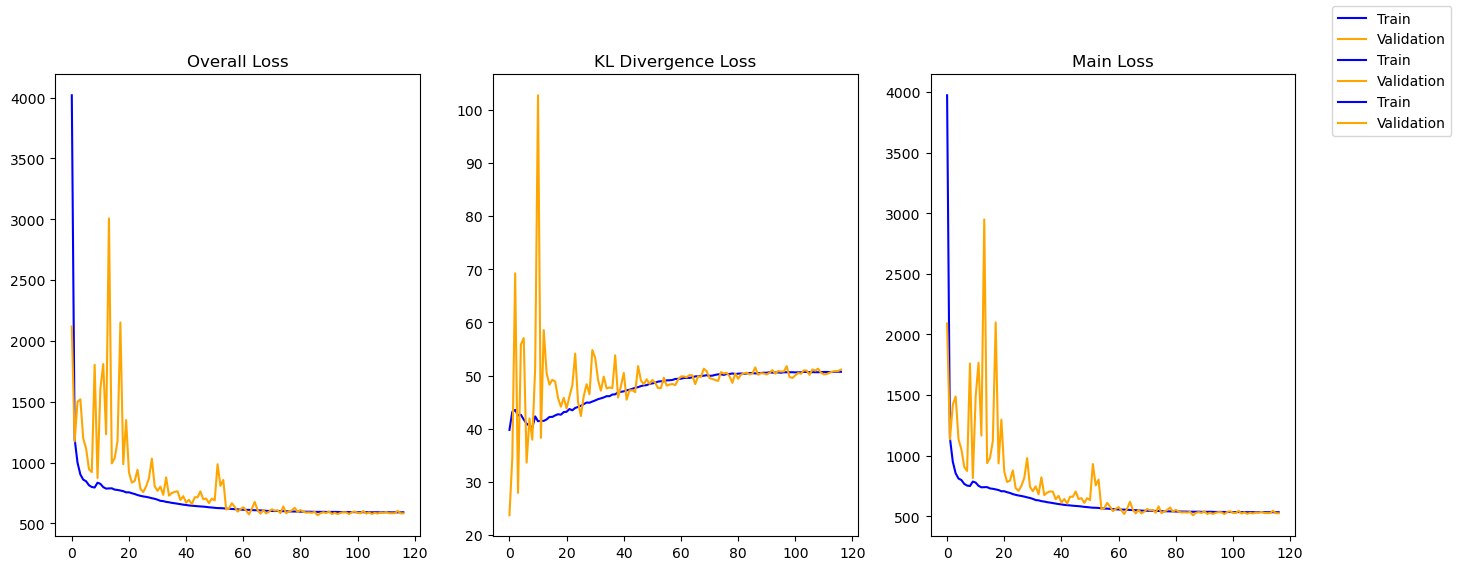

In [83]:
overall, kl_divergence, main = train(
    model=autoencoder,
    optimizer=optimizer,
    loss=loss,
    epochs=epochs,
    regularization_lambda=kl_divergence_lambda,
    dataloader=dataloader,
    val_dataset=val_dataset,
    scheduler=scheduler,
    plot=True,
    trial=None
)

overall_train_losses, val_overall_losses = overall
kl_divergence_train_losses, val_kl_divergence_train_losses = kl_divergence
main_train_losses, val_main_losses = main

In [84]:
image_to_generate = images[5121]
# getting a generated image from the original
with torch.no_grad():
    # expanding the channel
    original_batched_image = np.expand_dims(image_to_generate, axis=0)
    # expanding batch
    original_batched_image = np.expand_dims(original_batched_image, axis=0)
    _, _, _, generated_image = autoencoder(torch.from_numpy(original_batched_image) \
                                  .to(device=device, dtype=torch.float32))
    
    generated_image = generated_image.flatten(start_dim=0, end_dim=2)
    print(generated_image.shape)

    laplace_filtered_generated_image = sp.ndimage.laplace(generated_image.cpu().numpy(), mode='constant', cval=0)

torch.Size([176, 144])


(166.20976, 75.915665)

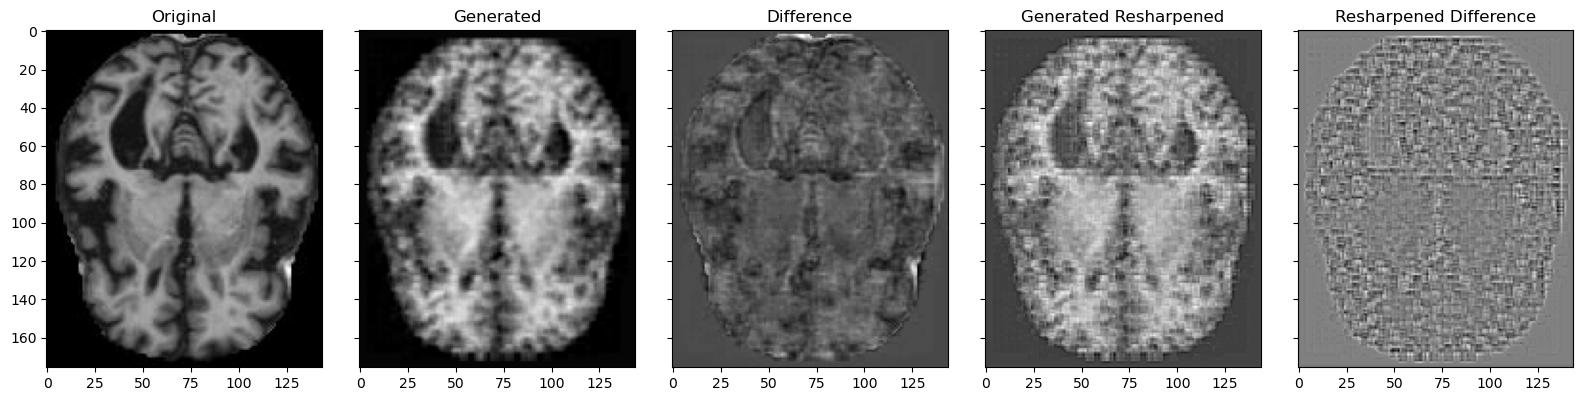

In [85]:
fig, axes = plt.subplots(1, 5, figsize=(16, 10), sharey=True, sharex=True)
fig.tight_layout()

axes[0].set_title('Original')
axes[0].imshow(image_to_generate, cmap='gray')
axes[1].set_title('Generated')
axes[1].imshow(generated_image.cpu(), cmap='gray')
axes[2].set_title('Difference')
axes[2].imshow(image_to_generate - generated_image.cpu().numpy(), cmap='gray')
axes[3].set_title('Generated Resharpened')
axes[3].imshow(generated_image.cpu().numpy() - laplace_filtered_generated_image, cmap='gray')
axes[4].set_title('Resharpened Difference')
axes[4].imshow(image_to_generate - (image_to_generate - laplace_filtered_generated_image), cmap='gray')
(image_to_generate - generated_image.cpu().numpy()).max(), (image_to_generate - (image_to_generate - laplace_filtered_generated_image)).max()

In [86]:
single_channel_images = np.expand_dims(images, axis=1)
# single_channels_images = dataset.X

with torch.no_grad():
    encoded_images, _, _, _ = encoder(torch.from_numpy(single_channel_images).to(device=device, dtype=torch.float32))
    encoded_images = encoded_images.cpu()

In [87]:
encoded_images.shape

torch.Size([10242, 414])

In [88]:
with torch.no_grad():
    _, _, _, decoded_images = autoencoder(torch.from_numpy(single_channel_images).to(device=device, dtype=torch.float32))
    decoded_images = decoded_images.cpu()
    # laplace_filtered_decoded_images = sp.ndimage.laplace(decoded_images, mode='constant', cval=0)
    # resharpened_decoded_images = decoded_images - laplace_filtered_decoded_images
    # decoded_images = resharpened_decoded_images

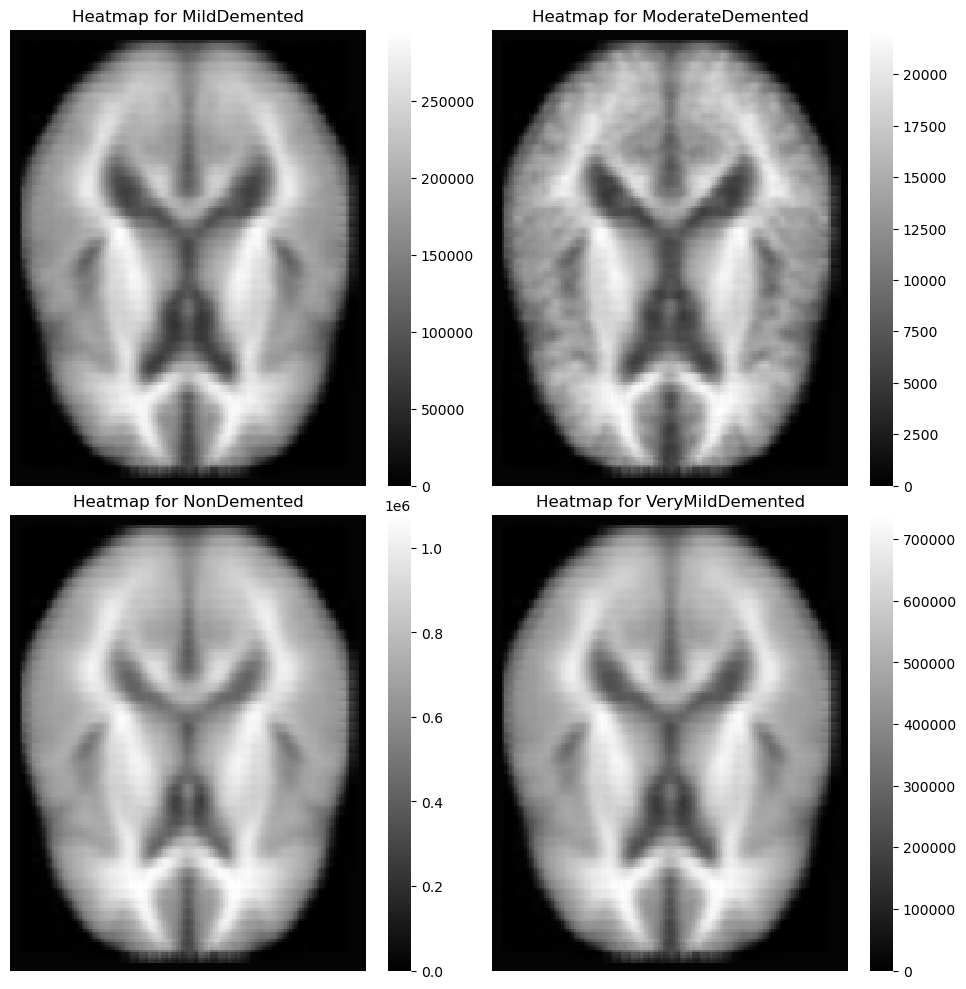

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = decoded_images.squeeze().detach().numpy()[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Heatmap for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

<Axes: ylabel='Count'>

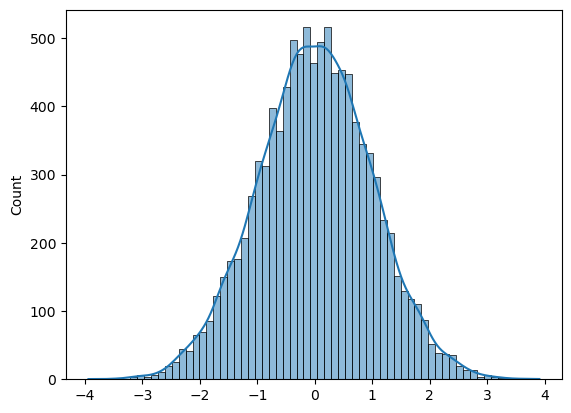

In [90]:
# plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=images_labels)
sns.histplot(encoded_images[:, 0], kde=True)

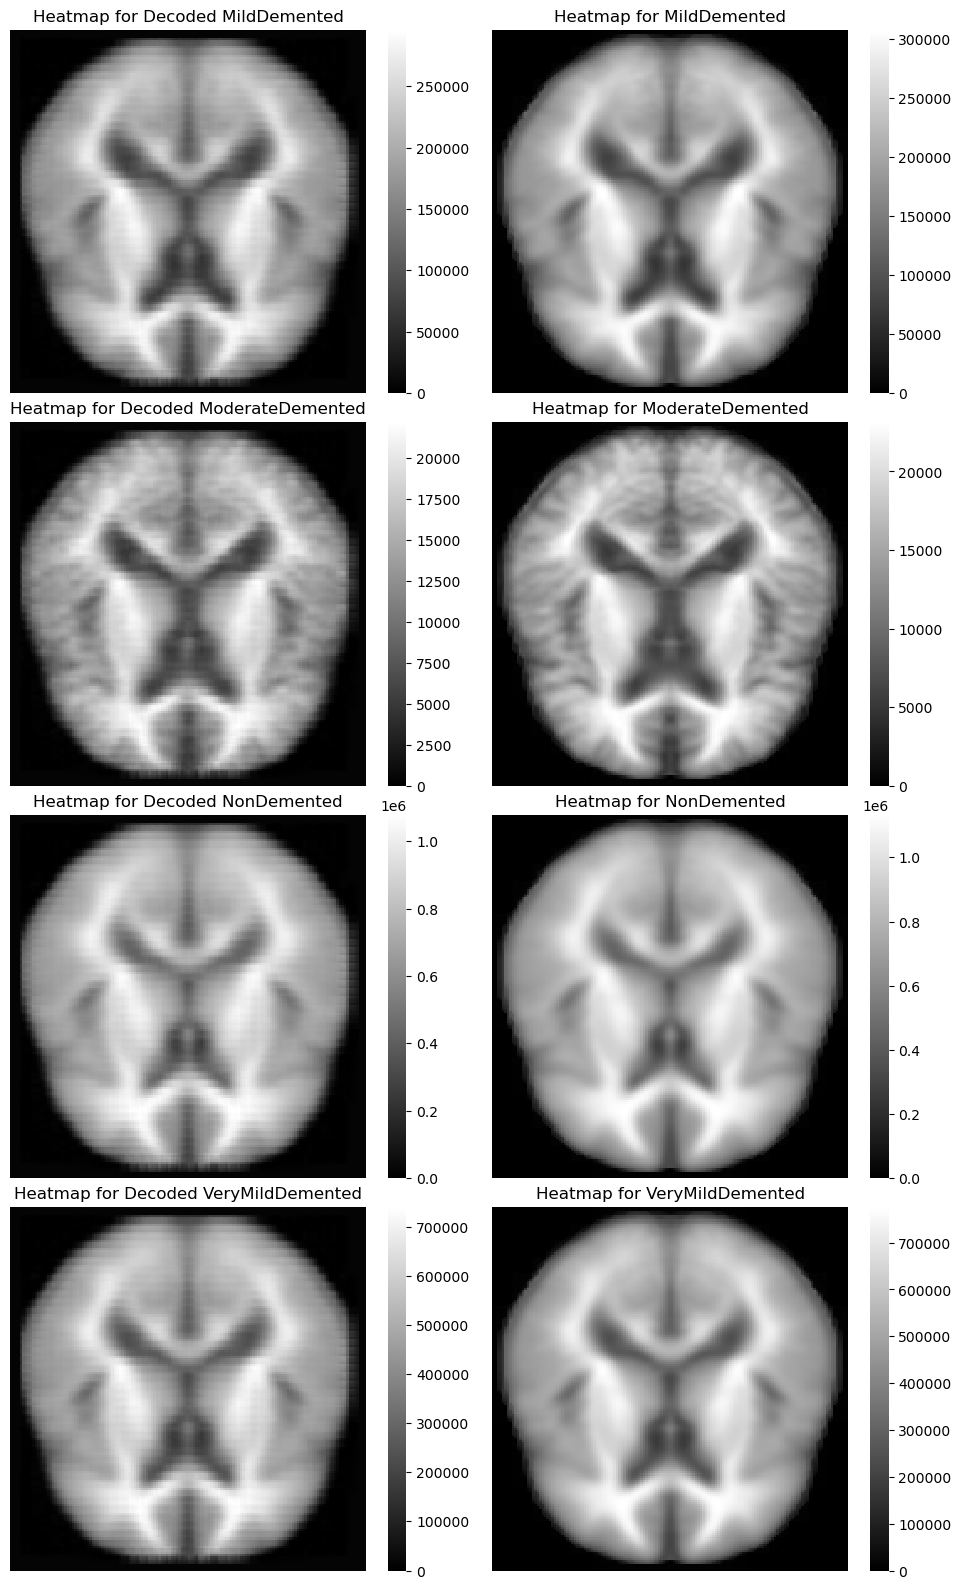

In [91]:
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax_generated = axes[i, 0]
    ax_original = axes[i, 1]
    generated_class_images = decoded_images.squeeze().detach().numpy()[np.where(images_labels == i)]
    original_class_images = images[np.where(images_labels == i)]
    original_heatmap = np.sum(original_class_images, axis=0)
    generated_heatmap = np.sum(generated_class_images, axis=0)
    sns.heatmap(generated_heatmap, ax=ax_generated, cmap='gray')
    sns.heatmap(original_heatmap, ax=ax_original, cmap='gray')
    
    ax_generated.set_title(f'Heatmap for Decoded {classes[i]}')
    ax_generated.get_yaxis().set_visible(False)
    ax_generated.get_xaxis().set_visible(False)
    
    ax_original.set_title(f'Heatmap for {classes[i]}')
    ax_original.get_yaxis().set_visible(False)
    ax_original.get_xaxis().set_visible(False)

In [92]:
from modules.models.utils import save_model

In [93]:
save_model(autoencoder, optimizer, best_params)

file ./saved_models/SGD-lr=0.006688453300893346-momentum=0.24668464332837217-dampening=0.09684209978086347-weight_decay=0.11503670509750329-initial_lr=0.006688453300893346-lr=0.006688453300893346kl_lambda=1.1462528683850681-epochs=117-encoded_dim=414-channels=8-bs=32-0.pt already exists, creating a new file...
file ./saved_models/SGD-lr=0.006688453300893346-momentum=0.24668464332837217-dampening=0.09684209978086347-weight_decay=0.11503670509750329-initial_lr=0.006688453300893346-lr=0.006688453300893346kl_lambda=1.1462528683850681-epochs=117-encoded_dim=414-channels=8-bs=32-1.pt already exists, creating a new file...
file ./saved_models/SGD-lr=0.006688453300893346-momentum=0.24668464332837217-dampening=0.09684209978086347-weight_decay=0.11503670509750329-initial_lr=0.006688453300893346-lr=0.006688453300893346kl_lambda=1.1462528683850681-epochs=117-encoded_dim=414-channels=8-bs=32-2.pt already exists, creating a new file...
file ./saved_models/SGD-lr=0.006688453300893346-momentum=0.24668

#### Adding noise in the spatial domain to the encoded output and cleaning it in the frequency domain of the decoded images to create new images

In [94]:
# final_images = np.concatenate((np.expand_dims(images, axis=1), decoded_images), axis=0)
final_images = np.expand_dims(images.copy(), axis=1)
# final_labels = np.concatenate((images_labels, images_labels), axis=0)
final_labels = images_labels.copy()

In [95]:
def transform_image(image, threshold=None):
    fft_image = np.fft.fft2(image)
    if threshold is None:
        threshold = 0.0005 * np.abs(fft_image)
    # creating a mask for zeroing low amplitudes, i.e: below the threshold
    mask = np.ones_like(fft_image)
    mask[np.abs(fft_image) <= threshold] = 0
    filtered_fft_image = fft_image * mask
    # getting the inverse fourier transform on the filtered image
    inverse_fft_image = np.fft.ifft2(filtered_fft_image)
    transformed_image = np.real(inverse_fft_image * np.conj(inverse_fft_image))
    # normalizing to [0, 255] range
    transformed_image = transformed_image / transformed_image.max()
    
    return transformed_image

In [96]:
desired_min_images = encoded_images.shape[0]
# number of times we'll add noise and decode the result
num_iterations = desired_min_images // encoded_images.shape[0]

for i in tqdm(range(num_iterations)):
    # indices_to_reset = torch.from_numpy(np.random.choice(np.arange(encoded_dim), int(0.1 * encoded_dim), replace=False))
    # encoded_images[:, indices_to_reset] = 0
    encoded_noise = torch.randn(encoded_images.shape)
    # encoded_noise = np.random.randn(*encoded_images.cpu().numpy().shape)
    noisy_images = encoded_images + encoded_noise
    
    with torch.no_grad():
        noisy_decoded_images = decoder(noisy_images.to(device=device, dtype=torch.float32)).cpu()
        # noisy_decoded_images = transform_image(noisy_decoded_images)
        # laplace_filtered_noisy_decoded_images = sp.ndimage.laplace(noisy_decoded_images, mode='constant', cval=0)
        # noisy_decoded_images = noisy_decoded_images - laplace_filtered_noisy_decoded_images
    
    final_images = np.concatenate((final_images, noisy_decoded_images), axis=0)
    final_labels = np.concatenate((final_labels, final_labels), axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [97]:
final_images.shape, final_labels.shape

((20484, 1, 176, 144), (20484,))

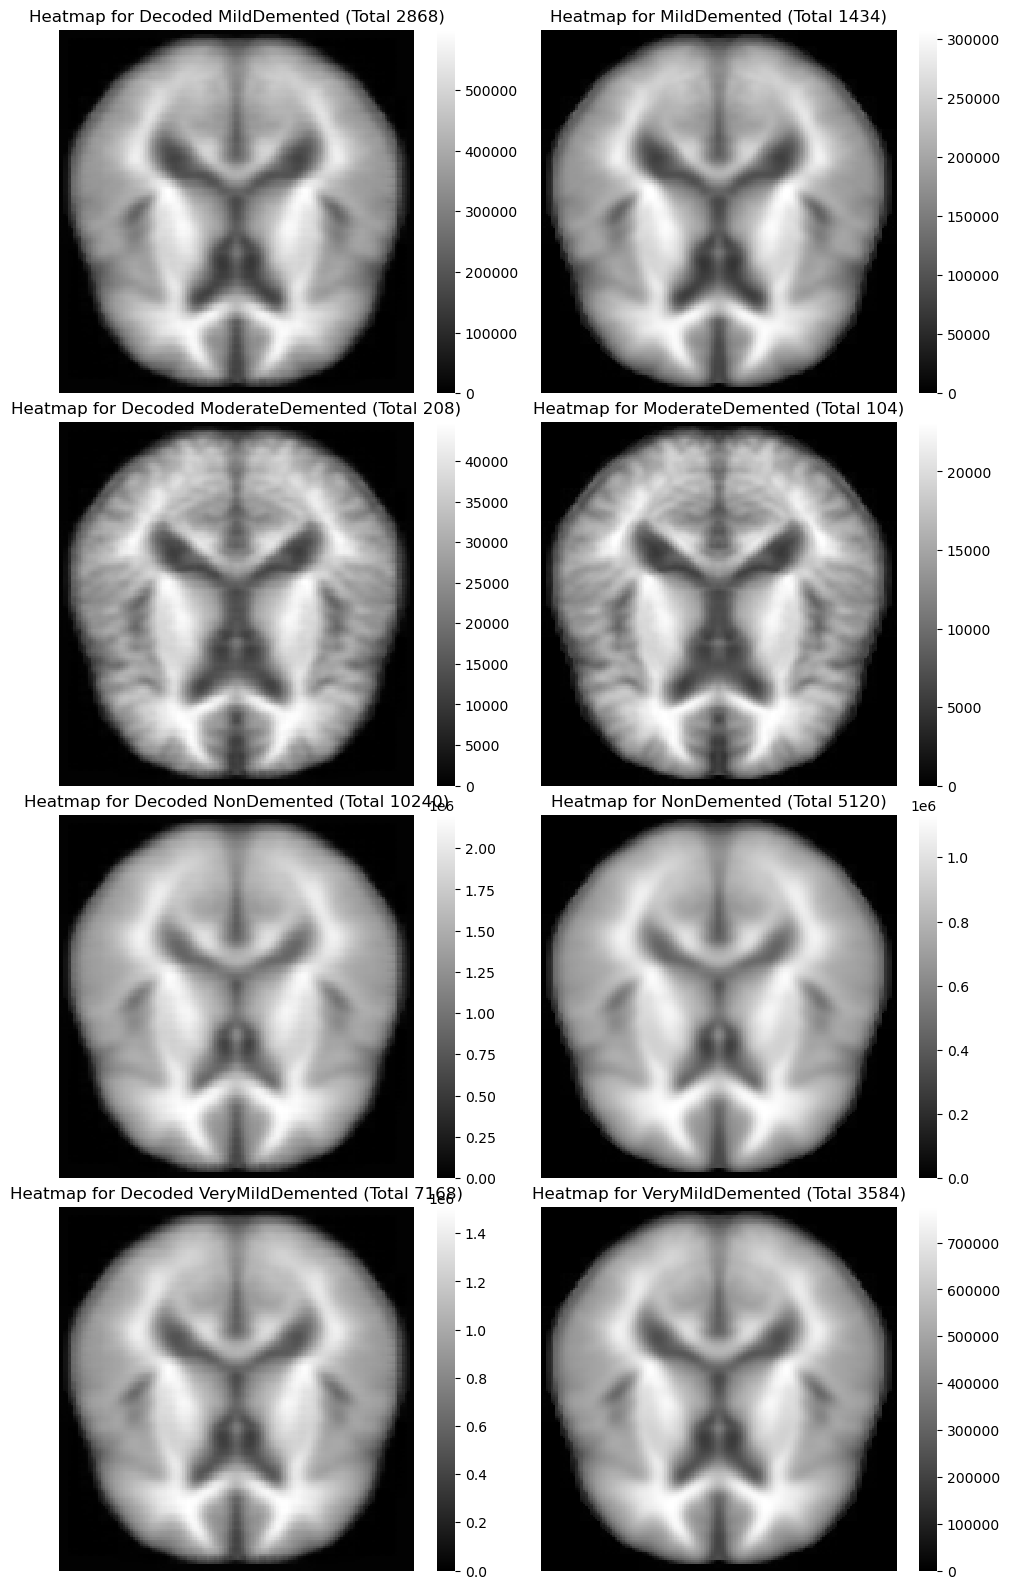

In [98]:
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax_generated = axes[i, 0]
    ax_original = axes[i, 1]
    generated_class_images = final_images.squeeze()[np.where(final_labels == i)]
    original_class_images = images[np.where(images_labels == i)]
    original_heatmap = np.sum(original_class_images, axis=0)
    generated_heatmap = np.sum(generated_class_images, axis=0)
    sns.heatmap(generated_heatmap, ax=ax_generated, cmap='gray')
    sns.heatmap(original_heatmap, ax=ax_original, cmap='gray')

    ax_generated.set_title(f'Heatmap for Decoded {classes[i]} (Total {generated_class_images.shape[0]})')
    ax_generated.get_yaxis().set_visible(False)
    ax_generated.get_xaxis().set_visible(False)

    ax_original.set_title(f'Heatmap for {classes[i]} (Total {original_class_images.shape[0]})')
    ax_original.get_yaxis().set_visible(False)
    ax_original.get_xaxis().set_visible(False)

#### Saving the decoded and generated images to disk for later use

In [99]:
saved_data_directories = [dir for dir in os.listdir('./data/') if dir.startswith('decoded_data')]
directories_nums = [int(dir.split('_')[-1]) for dir in saved_data_directories if dir.split('_')[-1].isdigit()]
last_directory_num = max(directories_nums)

In [100]:
import h5py

In [101]:
directory_name = f'./data/decoded_data_{last_directory_num + 1}'
if not os.path.exists(directory_name):
    os.mkdir(directory_name)
    
    # saving original data
    with h5py.File(f'{directory_name}/images.h5', 'w') as h5f_images_file:
        h5f_images_file.create_dataset('images', data=images, dtype='i')

    with h5py.File(f'{directory_name}/labels.h5', 'w') as h5f_labels_file:
        h5f_labels_file.create_dataset('labels', data=images_labels, dtype='i')

    # training dataset
    with h5py.File(f'{directory_name}/train_images.h5', 'w') as h5f_train_images_file:
        h5f_train_images_file.create_dataset('images', data=images[train_indices], dtype='i')

    with h5py.File(f'{directory_name}/train_labels.h5', 'w') as h5f_train_labels_file:
        h5f_train_labels_file.create_dataset('labels', data=images_labels[train_indices], dtype='i')

    # validation dataset
    with h5py.File(f'{directory_name}/val_images.h5', 'w') as h5f_val_images_file:
        h5f_val_images_file.create_dataset('images', data=images[val_indices], dtype='i')

    with h5py.File(f'{directory_name}/val_labels.h5', 'w') as h5f_val_labels_file:
        h5f_val_labels_file.create_dataset('labels', data=images_labels[val_indices], dtype='i')

    # generated dataset
    with h5py.File(f'{directory_name}/final_images.h5', 'w') as h5f_generated_images_file:
        h5f_generated_images_file.create_dataset('final_images', data=final_images, dtype='i')

    with h5py.File(f'{directory_name}/final_labels.h5', 'w') as h5f_generated_labels_file:
        h5f_generated_labels_file.create_dataset('final_labels', data=final_labels, dtype='i')

In [102]:
del final_images
del final_labels

In [103]:
import shutil

shutil.rmtree(f'./logs/augmentation/{study_name}')